In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as c

from tqdm.autonotebook import tqdm as tqdm
import corner

from threeML import *

plt.style.use('thomas')

/Users/thomassiegert/.virtualenvs/3ml_stuff/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
[WARNING ] ROOT minimizer not available
[WARNING ] PyGMO is not available
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?



WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



[WARNING ] Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML
[WARNING ] Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML
[WARNING ] Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


In [2]:
import warnings
warnings.simplefilter("ignore")

<h3>Path where to find the spimodfit run with all the spectra and response files</h3>

In [3]:
spec_path = '/Users/thomassiegert/data/SPI/511keV_allsky/fit_511keV_6keV_40bins_0043-2679_SE_v02_bgmod03_filter01/'

<h3>Creating a likelihood object that has a (unique) name and holds the observation and the response</h3>

In [ ]:
fg511 = OGIPLike(name='fg511',
                 observation=spec_path+'spectra_SkyModel_01.fits',
                 response=spec_path+'spectral_response.rmf.fits')

hdul = fits.open('observation')

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None


<h3>Looking at the spectrum (note that the units are not correct here as the $\mathrm{cm^{-2}}$ is missing; this has reason which I might explain at some point later)<br>
We look at the spectrum in linear axes so that we see what's going on</h3>

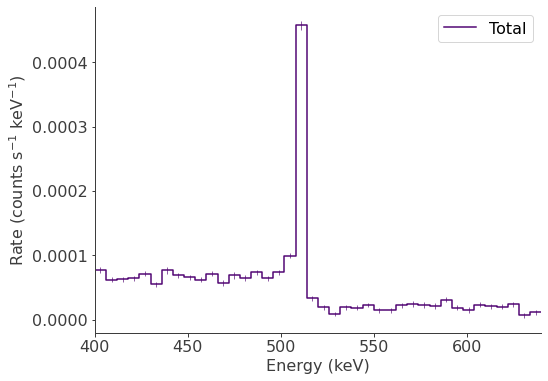

In [5]:
fg511.view_count_spectrum()
plt.xscale('linear')
plt.yscale('linear')

<h3>Definition of the energy bins (same as the energy boundaries file)</h3>

In [6]:
dee = fg511.energy_boundaries[1]-fg511.energy_boundaries[0]
ee = 0.5*(fg511.energy_boundaries[1]+fg511.energy_boundaries[0])
n_ee = len(ee)

<h3>Selecting which energy bins to fit (here: all because the fits are adequate everywhere)</h3>

In [7]:
fg511.set_active_measurements('c0-c39')

[INFO    ] Range c0-c39 translates to channels 0-39


<h3>Same plot again (would change if the channels were selected differently</h3>

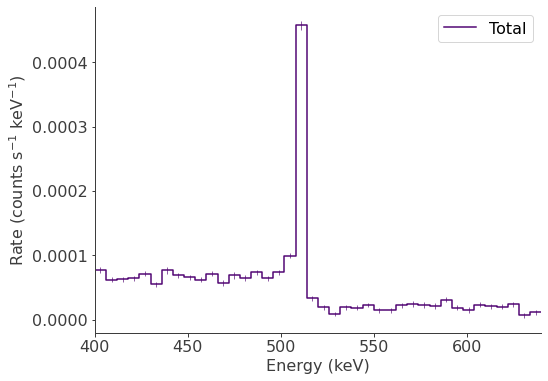

In [8]:
fg511.view_count_spectrum()
plt.xscale('linear')
plt.yscale('linear')

<h3>Importing the Positronium function (check out how this function works!)</h3>

In [9]:
from Positronium_Spectrum import Positronium_Spectrum

<h3>Defining a model in 3ML includes a spectrum and a definition of where the source is;<br>
    We already defined our sources as being extended sources or point sources, so that we just include an arbitrary value for the coordinates;<br>
    The response as it is now doesn't know coordinates, so the positions don't matter</h3>

In [10]:
fg511_spectrum = Powerlaw(K=1e-5,piv=500,index=-1.7) + Positronium_Spectrum(Flux=2.7e-3,f_Ps=1.0)

fg511_source = PointSource("fg511", l=0, b=0, spectral_shape=fg511_spectrum)

fg511_model = Model(fg511_source)

fg511_data = DataList(fg511)

fg511_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (4):
--------------------

                                         value min_value max_value  \
fg511.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
fg511.spectrum.main.composite.index_1     -1.7     -10.0      10.0   
fg511.spectrum.main.composite.Flux_2    0.0027       0.0    1000.0   
fg511.spectrum.main.composite.f_Ps_2       1.0       0.0       1.0   

                                                 unit  
fg511.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
fg511.spectrum.main.composite.index_1                  
fg511.spectrum.main.composite.Flux_2         s-1 cm-2  
fg511.spectrum.main.composite.f_Ps_2                   

Fixed parameters (5):
---------------------

                                       value min_value max_value unit
fg511.position.l                         0.0       0.0     360.0  deg
fg511.position.b                         0.0     -90.0      90.0  deg
fg511.spectrum.main.composite.piv_1    500.0      None      None  keV
fg511.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
fg511.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

<h3>Doing a maximum likelihood fit (for reference)</h3>

In [11]:
fg511_jl = JointLikelihood(fg511_model, fg511_data)

best_fit_parameters_fg511, likelihood_values_fg511 = fg511_jl.fit()

[INFO    ] set the minimizer to minuit
[WARNING ] 51.12 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
fg511.spectrum.main.composite.K_1,(2.31 -0.06 +0.07) x 10^-5,1 / (cm2 keV s)
fg511.spectrum.main.composite.index_1,-1.36 +/- 0.20,
fg511.spectrum.main.composite.Flux_2,(2.123 +/- 0.030) x 10^-3,1 / (cm2 s)
fg511.spectrum.main.composite.f_Ps_2,(10.00000 +/- 0.00005) x 10^-1,



Correlation matrix:



1.00,0.03,-0.45,-0.00
0.03,1.00,0.21,0.00
-0.45,0.21,1.00,-0.00
-0.00,0.00,-0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fg511,63.224954
total,63.224954



Values of statistical measures:



,statistical measures
AIC,135.592765
BIC,141.205425


<h3>You see extremely small uncertainties, for example for the Positronium fraction, which is most certainly not real. In any case, the maximum likelihood solution gives a first-order look, but we will use a Bayesian fit to also obtain more reliable uncertainties</h3>

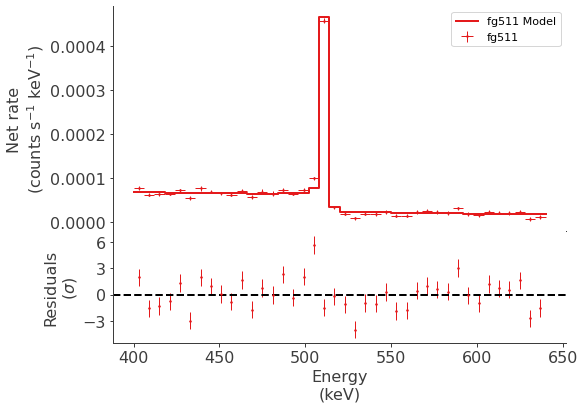

In [12]:
fg511_jl.restore_best_fit()
wa = display_spectrum_model_counts(fg511_jl,step=True,)
wa.axes[0].set_xscale('linear')
wa.axes[0].set_yscale('linear')

<h3>Now Bayesian fit: this requires the definition of priors for all free parameters</h3>

In [13]:
# power law
fg511_model.fg511.spectrum.main.composite.piv = 500.
fg511_model.fg511.spectrum.main.composite.K_1.prior = Truncated_gaussian(F=1, mu = 2e-5, sigma = 1e-4, lower_bound=1e-50)
#fg511_model.fg511.spectrum.main.composite.index_1.prior = Uniform_prior(lower_bound=-3,upper_bound=0)
fg511_model.fg511.spectrum.main.composite.index_1.prior = Gaussian(F=1,mu=-1.4,sigma=0.2)

# Positronium
fg511_model.fg511.spectrum.main.composite.Flux_2.prior = Gaussian(F=1, mu=2.7e-3, sigma= 0.3e-3)
fg511_model.fg511.spectrum.main.composite.f_Ps_2.prior = Truncated_gaussian(F=1,mu=1,sigma=0.3,lower_bound=0,upper_bound=1)
fg511_model.fg511.spectrum.main.composite.sigma_2.prior = Gaussian(F=1, mu=2.1, sigma= 0.3)
fg511_model.fg511.spectrum.main.composite.sigma_2.free = True

<h3>Setting up the fit and fitting with multinest (might take a minute or so)</h3>

In [14]:
fg511_bs = BayesianAnalysis(fg511_model, fg511_data)
fg511_bs.set_sampler("multinest")
fg511_bs.sampler.setup(n_live_points=1000)
fg511_samples = fg511_bs.sample(quiet=False)

[WARNING ] External parameter cons_fg511 already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    5
 *****************************************************
 ln(ev)=  -60.866486965112891      +/-  0.10410920342149452     
 Total Likelihood Evaluations:        38099
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
fg511.spectrum.main.composite.K_1,(2.03 -0.09 +0.08) x 10^-5,1 / (cm2 keV s)
fg511.spectrum.main.composite.index_1,-1.19 -0.16 +0.15,
fg511.spectrum.main.composite.Flux_2,(2.48 +/- 0.06) x 10^-3,1 / (cm2 s)
fg511.spectrum.main.composite.sigma_2,1.76 -0.06 +0.05,keV
fg511.spectrum.main.composite.f_Ps_2,(9.92 -0.07 +0.06) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
fg511,-40.312334
total,-40.312334



Values of statistical measures:



,statistical measures
AIC,92.389373
BIC,99.069065
DIC,89.815774
PDIC,3.755435
log(Z),-26.433979


<h3>now the uncertainties appear more reasonable, but the parameters may not be actual ones;<br>
    we first need to understand in how far the fit converged to and look at the Monte Carlo chains</h3>

<h3>Extracting the samples</h3>

In [15]:
fg511_bs_samples = fg511_bs.results.samples

<h3>Plotting the raw parameter chains</h3>

[<Figure size 576x432 with 1 Axes>,
 <Figure size 576x432 with 1 Axes>,
 <Figure size 576x432 with 1 Axes>,
 <Figure size 576x432 with 1 Axes>,
 <Figure size 576x432 with 1 Axes>]

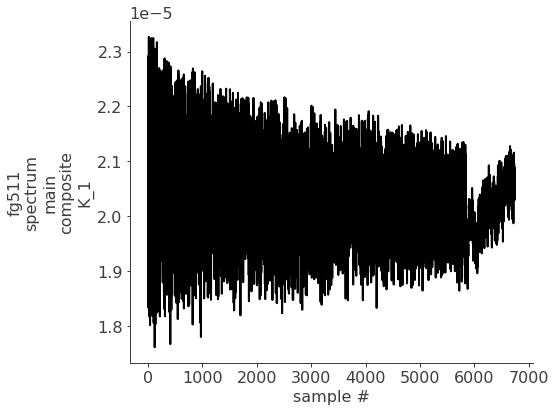

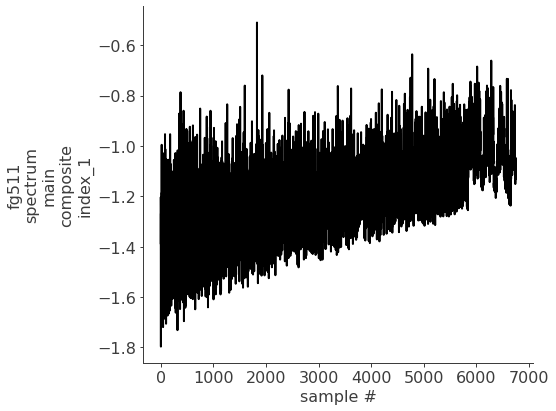

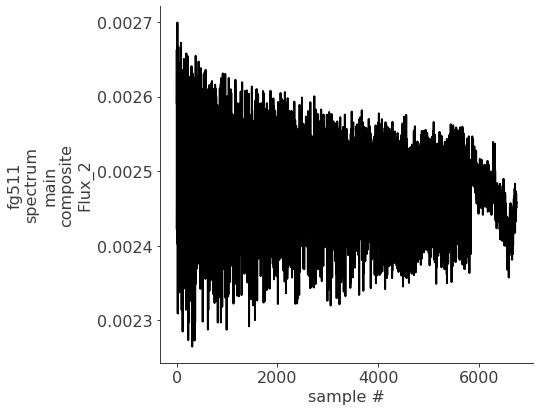

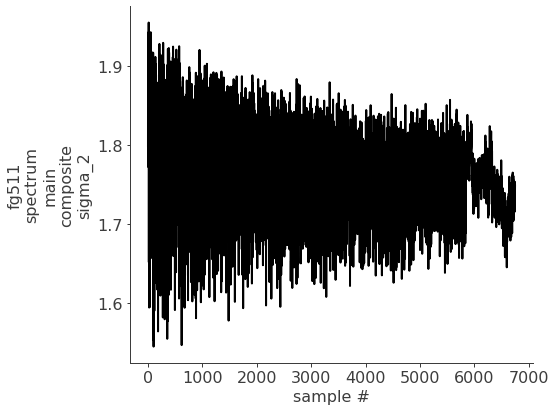

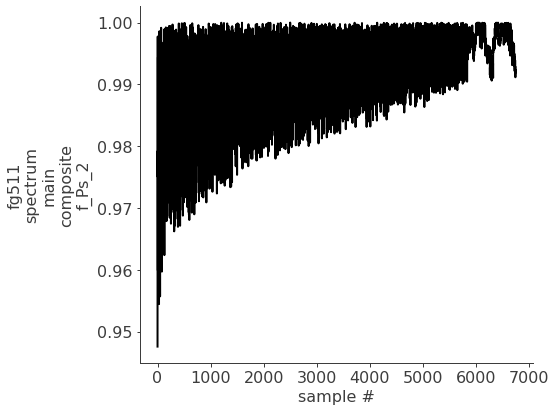

In [16]:
fg511_bs.plot_chains()

<h3>you see that the chains, even after a few 1000 smaples, do not behave smoothly and with a unique standard deviation;<br>
    we would need to increase the number of multinest livepoints to get a better (i.e. more robust) estimate of the parameters and their uncertainties<br>
    here, we will continue with what we have and only select the last 1000 samples</h3>

In [17]:
n_samples = len(fg511_bs_samples[0,:])
print(n_samples)

n_use = 1000
offset = n_samples-n_use
print(offset)

6747
5747


<h3>Scale for the parameter in the corner plot</h3>

In [18]:
scl = np.array([1e5,1,1e3,1,1])

<h3>Plotting the posteriors of the parameters (last 1000 samples each)</h3>

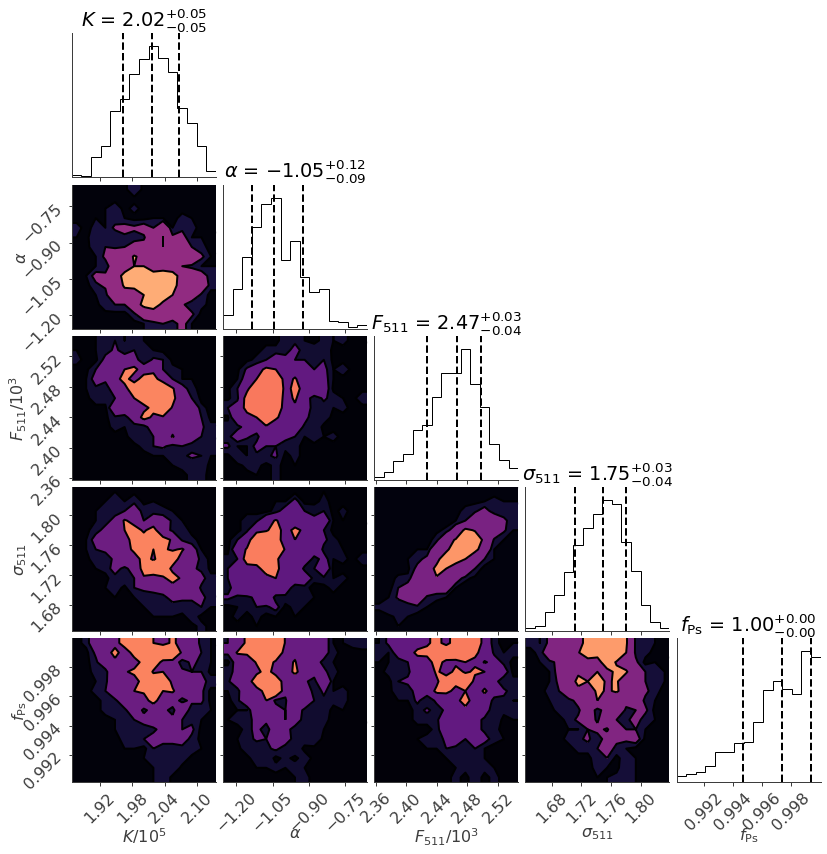

In [19]:
sigma = 68.3
titles = [r'$K$',r'$\alpha$',r'$F_{511}$',r'$\sigma_{511}$',r'$f_{\rm Ps}$']
labels = [r'$K/10^5$',r'$\alpha$',r'$F_{511}/10^3$',r'$\sigma_{511}$',r'$f_{\rm Ps}$']
fig = corner.corner(fg511_bs_samples[:,offset:].T*scl,
                    #truths=np.array([1,2,3,4]),
                    quantiles=(50+sigma/np.array([-2,np.inf,+2]))/100.,
                    #quantiles=(0.16, 0.50, 0.84),
                    titles=titles,
                    labels=labels,
                    show_titles=True,
                    bins=15,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.magma, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    truth_color='orange',);

<h3>Note that the parameters are somewhat different than in the fit results from multinest because we only use the last 1000 samples;<br>
    use these (last X samples) to calculate everything else and propagate parameters and uncertainties</h3>

<h3>Creating posterior models (i.e. one spectrum for each set of parameters that fit the data)</h3>

In [20]:
# looping over the samples to create model posteriors

# use 10000 samples in total
n_use = 1000

# model evaluation at 1000 points logarithmically spaced between 30 and 8000 keV
N_model = 1000
x_model = np.linspace(400,640,N_model)

y_models_total = np.zeros((N_model,n_use))
y_models_powerlaw = np.zeros((N_model,n_use))
y_models_positron = np.zeros((N_model,n_use))

n_use_d = int(n_use/1)
d_models_total = np.zeros((n_ee,n_use_d))
d_models_powerlaw = np.zeros((n_ee,n_use_d))
d_models_positron = np.zeros((n_ee,n_use_d))


# and looping
offset = n_samples-n_use
for i in tqdm(range(offset,n_samples)):

    # powerlaw spectrum
    powerlaw_spec = Powerlaw(K=fg511_bs_samples[0,i],piv=500,index=fg511_bs_samples[1,i])
    y_models_powerlaw[:,i-offset] = powerlaw_spec.fast_call(x_model)
    tmp_source_powerlaw = PointSource("tmp_powerlaw", l=0, b=0, spectral_shape=powerlaw_spec)
    tmp_model_powerlaw = Model(tmp_source_powerlaw)
    fg511.set_model(tmp_model_powerlaw)
    powerlaw_d = fg511.expected_model_rate
    d_models_powerlaw[:,i-offset] = powerlaw_d/dee

    # positronium spectrum
    positron_spec = Positronium_Spectrum(Flux=fg511_bs_samples[2,i],f_Ps=fg511_bs_samples[4,i],sigma=fg511_bs_samples[3,i])
    y_models_positron[:,i-offset] = positron_spec.fast_call(x_model)
    tmp_source_positron = PointSource("tmp_positron", l=0, b=0, spectral_shape=positron_spec)
    tmp_model_positron = Model(tmp_source_positron)
    fg511.set_model(tmp_model_positron)
    positron_d = fg511.expected_model_rate
    d_models_positron[:,i-offset] = positron_d/dee


    total_spec = powerlaw_spec+positron_spec
    y_models_total[:,i-offset] = total_spec.fast_call(x_model)
    tmp_source = PointSource("tmp", l=0, b=0, spectral_shape=total_spec)
    tmp_model = Model(tmp_source)
    fg511.set_model(tmp_model)
    total_d = fg511.expected_model_rate
    d_models_total[:,i-offset] = total_d/dee


  0%|          | 0/1000 [00:00<?, ?it/s]

<h3>levels for the posterior plots</h3>

In [21]:
levels = [68.3,95.4,99.7]

<h3>reading in the raw spectrum again for plotting</h3>

In [22]:
fg511_spec = fits.open(spec_path+'spectra_SkyModel_01.fits')

<h3>defining minimum and maximum plotting range depending on the measured fluxes</h3>

In [23]:
ymin, ymax = np.abs(fg511_spec[2].data['DFLUX']).min()*0.5,(fg511_spec[2].data['DFLUX']+fg511_spec[2].data['DFLUX_ERR']).max()*1.5

<h3>plot the posterior model (one can make it nicer, e.g. in terms of the legend, but fine for now)</h3>

(400.0, 640.0)

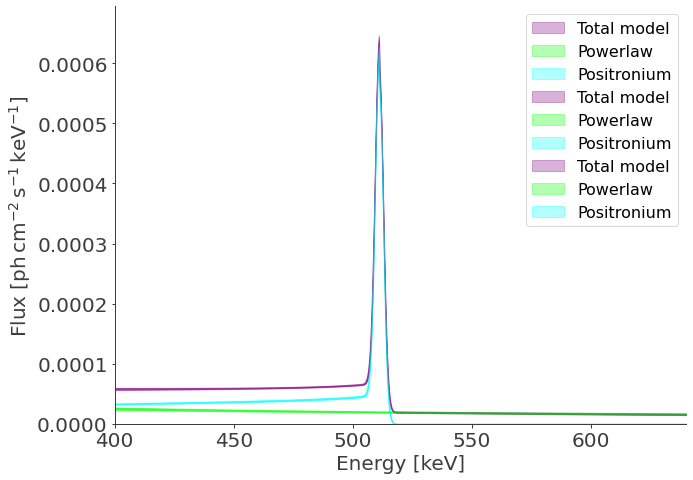

In [24]:
plt.figure(figsize=(10.24,7.68))

edx = 0


for level in levels:

    plt.fill_between(x_model,
                    np.percentile(y_models_total,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_total,50-level/2,axis=1)*x_model**edx,
                    color='purple',alpha=0.3,label='Total model')

    plt.fill_between(x_model,
                    np.percentile(y_models_powerlaw,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_powerlaw,50-level/2,axis=1)*x_model**edx,
                    color='lime',alpha=0.3,label='Powerlaw')

    plt.fill_between(x_model,
                    np.percentile(y_models_positron,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_positron,50-level/2,axis=1)*x_model**edx,
                    color='cyan',alpha=0.3,label='Positronium')


plt.xscale('linear')
plt.yscale('linear')
if edx == 0:
    plt.ylim(0,ymax)
    plt.xlabel('Energy [keV]',fontsize=20)
    plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
    plt.legend()

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(400,640)

#plt.savefig(paper_dir+'total_spectrum_model_eeflux.pdf')

<h3>plotting the thing in data space with residuals (could make a function out of that ...)</h3>

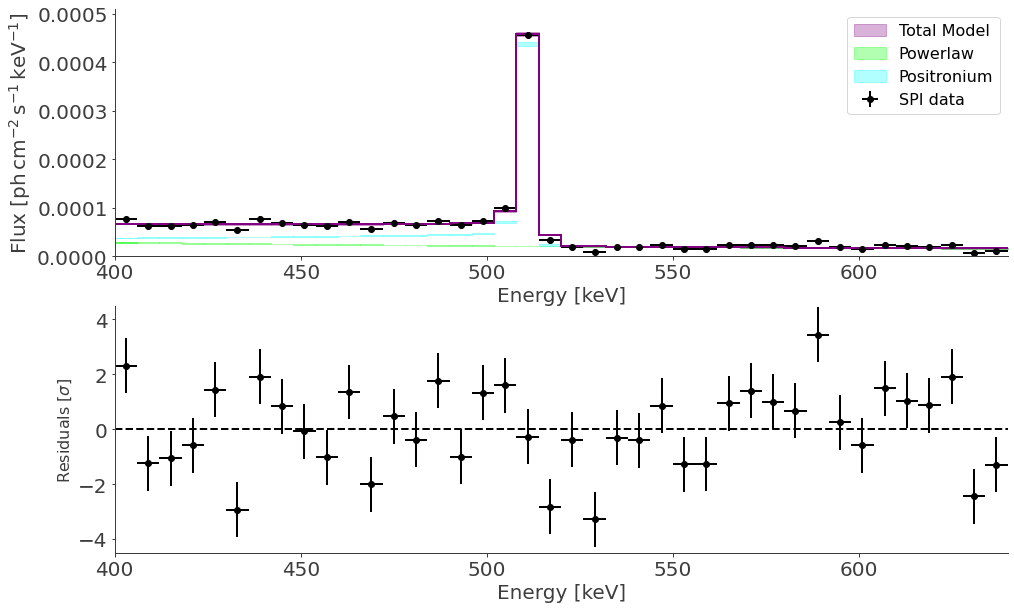

In [25]:
ymin, ymax = np.abs(fg511_spec[2].data['DFLUX']).min()*0.5, (fg511_spec[2].data['DFLUX']+fg511_spec[2].data['DFLUX_ERR']).max()*1.1

edx = 0

plt.figure(figsize=(16,10))

plt.subplot(211)
for level in levels[0:1]:

    for i in range(len(ee)):

        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_total[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_total[i,:],50-level/2),2)*ee[i]**edx,
                         color='purple',alpha=0.3,step='mid')

        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_powerlaw[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_powerlaw[i,:],50-level/2),2)*ee[i]**edx,
                         color='lime',alpha=0.3,step='mid')

        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_positron[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_positron[i,:],50-level/2),2)*ee[i]**edx,
                         color='cyan',alpha=0.3,step='mid')

        plt.plot([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                  np.repeat(np.percentile(d_models_total[i,:],50),2)*ee[i]**edx,
                       linewidth=2,color='purple')
        if i != 39:
                plt.plot([ee[i]+dee[i]/2,ee[i+1]-dee[i+1]/2],
                           [np.percentile(d_models_total[i,:],50)*ee[i]**edx,
                            np.percentile(d_models_total[i+1,:],50)*ee[i+1]**edx],
                           linewidth=2,color='purple')


plt.errorbar(ee,fg511_spec[2].data['DFLUX']*ee**edx,
                     xerr=dee/2,yerr=fg511_spec[2].data['DFLUX_ERR']*ee**edx,
                     linestyle='',marker='o',label='SPI data')

# could include gray regions to exclude if channels are excluded
"""plt.fill_between([472,472,490,490,472],
                 [-4.5,4.5,4.5,-4.5,-4.5],
                 color='gray',alpha=0.1)

plt.fill_between([568,568,580,580,568],
                 [ymin,ymax,ymax,ymin,ymin],
                 color='gray',alpha=0.1)"""

#plt.xscale('log')
#plt.yscale('log')

plt.xlim(400,640)

if edx == 0:
    plt.ylim(0,ymax)
    plt.xlabel('Energy [keV]',fontsize=20)
    plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

i = 0

plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                 np.repeat(np.percentile(d_models_total[i,:],50+level/2),2)*ee[i]**edx,
                 np.repeat(np.percentile(d_models_total[i,:],50-level/2),2)*ee[i]**edx,
                 color='purple',alpha=0.3,step='mid',label='Total Model')

plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                 np.repeat(np.percentile(d_models_powerlaw[i,:],50+level/2),2)*ee[i]**edx,
                 np.repeat(np.percentile(d_models_powerlaw[i,:],50-level/2),2)*ee[i]**edx,
                 color='lime',alpha=0.3,step='mid',label='Powerlaw')

plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                 np.repeat(np.percentile(d_models_positron[i,:],50+level/2),2)*ee[i]**edx,
                 np.repeat(np.percentile(d_models_positron[i,:],50-level/2),2)*ee[i]**edx,
                 color='cyan',alpha=0.3,step='mid',label='Positronium')

plt.legend()

plt.subplot(212)

plt.errorbar(ee,(fg511_spec[2].data['DFLUX']-np.percentile(d_models_total,50,axis=1))/fg511_spec[2].data['DFLUX_ERR'],
                     xerr=dee/2,yerr=fg511_spec[2].data['DFLUX_ERR']/fg511_spec[2].data['DFLUX_ERR'],
                     linestyle='',marker='o')

"""plt.fill_between([472,472,490,490,472],
                 [-4.5,4.5,4.5,-4.5,-4.5],
                 color='gray',alpha=0.1)

plt.fill_between([568,568,580,580,568],
                 [-4.5,4.5,4.5,-4.5,-4.5],
                 color='gray',alpha=0.1)"""

plt.ylabel(r'Residuals [$\sigma$]')

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(400,640)
plt.ylim(-4.5,4.5)

plt.axhline(0,linestyle='--')

#plt.savefig(paper_dir+'total_spectrum_fit_ALL_SYS2_residuals.pdf')

<h3>Function for doing the same thing for point sources in the list<br>
    see below the function for its usage</h3>

In [26]:
def analyse_point_source(spec_name,name=''):

    src_spec = fits.open(spec_path+spec_name)

    ymin, ymax = np.abs(src_spec[2].data['DFLUX']).min()*0.5, (src_spec[2].data['DFLUX']+src_spec[2].data['DFLUX_ERR']).max()*2

    src = OGIPLike(name='src',
                     observation=spec_path+spec_name,
                     response=spec_path+'spectral_response.rmf.fits')

    src.view_count_spectrum()
    plt.xscale('linear')
    plt.yscale('linear')

    src.set_active_measurements('c0-c39')

    src.view_count_spectrum()
    plt.xscale('linear')
    plt.yscale('linear')


    src_spectrum = Powerlaw(K=1e-5,piv=500,index=-2.2) + Positronium_Spectrum(Flux=1e-5,f_Ps=1.0)
    src_source = PointSource("src", l=0, b=0, spectral_shape=src_spectrum)
    src_model = Model(src_source)
    src_model.src.spectrum.main.composite.f_Ps_2.fix = True
    src_model.src.spectrum.main.composite.f_Ps_2 = 0
    src_data = DataList(src)
    src_model.display(complete=True)

    try:
        src_jl = JointLikelihood(src_model, src_data)
        best_fit_parameters_src, likelihood_values_src = src_jl.fit()

        src_jl.restore_best_fit()
        wa = display_spectrum_model_counts(src_jl,step=True,)
        wa.axes[0].set_xscale('linear')
        wa.axes[0].set_yscale('linear')
    except:
        print('wtf')


    src_model.src.spectrum.main.composite.piv = 500.
    src_model.src.spectrum.main.composite.K_1.prior = Truncated_gaussian(F=1, mu = 2e-5, sigma = 1e-4, lower_bound=1e-50)
    src_model.src.spectrum.main.composite.index_1.prior = Uniform_prior(lower_bound=-4,upper_bound=2)
    src_model.src.spectrum.main.composite.Flux_2.prior = Truncated_gaussian(F=1, mu=1e-7, sigma= 1e-3,lower_bound=0)
    src_model.src.spectrum.main.composite.f_Ps_2.fix = True
    src_model.src.spectrum.main.composite.f_Ps_2 = 0
    src_model.src.spectrum.main.composite.sigma_2.fix = True
    src_model.src.spectrum.main.composite.sigma_2 = 0.9

    src_bs = BayesianAnalysis(src_model, src_data)
    src_bs.set_sampler("multinest")
    src_bs.sampler.setup(n_live_points=1000)
    src_samples = src_bs.sample(quiet=True)

    src_bs_samples = src_bs.results.samples
    n_samples = src_bs_samples.shape[1]
    
    plt.figure()
    plt.plot(src_bs_samples[2,:])

    n_use = 1000
    offset = n_samples-n_use
    
    
    sigma = 68.3
    scl = np.array([1e6,1,1e6])
    labels = [r'$K$/10^6',r'$\alpha$',r'$F_{511}/10^6$']
    titles = [r'$K$',r'$\alpha$',r'$F_{511}$']
    fig = corner.corner(src_bs_samples[:,offset:].T*scl,
                        quantiles=(50+sigma/np.array([-2,np.inf,+2]))/100.,
                        #quantiles=(0.16, 0.50, 0.84),
                        show_titles=True,
                        labels=labels,
                        titles=titles,
                        bins=15,
                        fill_contours=True,
                        contourf_kwargs={"cmap": plt.cm.magma, "colors":None},
                        levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                        truth_color='orange')
    fig.set_size_inches(10,10)

    """src_bs.results.corner_plot(
                        #truths=np.array([1,2,3,4]),
                        quantiles=(50+sigma/np.array([-2,np.inf,+2]))/100.,
                        #quantiles=(0.16, 0.50, 0.84),
                        show_titles=True,
                        bins=25,
                        fill_contours=True,
                        contourf_kwargs={"cmap": plt.cm.magma, "colors":None},
                        levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                        truth_color='orange');"""




    # looping over the samples to create model posteriors

    # use 1000 samples in total
    # n_use = 1000

    # model evaluation at 1000 points logarithmically spaced between 30 and 8000 keV
    N_model = 1000
    x_model = np.linspace(400,640,N_model)

    y_models_total = np.zeros((N_model,n_use))
    y_models_powerlaw = np.zeros((N_model,n_use))
    y_models_positron = np.zeros((N_model,n_use))

    n_use_d = int(n_use/1)
    d_models_total = np.zeros((40,n_use_d))
    d_models_powerlaw = np.zeros((40,n_use_d))
    d_models_positron = np.zeros((40,n_use_d))


    # and looping

    for i in tqdm(range(offset,n_samples)):

        # powerlaw spectrum
        powerlaw_spec = Powerlaw(K=src_bs_samples[0,i],piv=500,index=src_bs_samples[1,i])
        y_models_powerlaw[:,i-offset] = powerlaw_spec.fast_call(x_model)
        tmp_source_powerlaw = PointSource("tmp_powerlaw", l=0, b=0, spectral_shape=powerlaw_spec)
        tmp_model_powerlaw = Model(tmp_source_powerlaw)
        src.set_model(tmp_model_powerlaw)
        powerlaw_d = src.expected_model_rate
        d_models_powerlaw[:,i-offset] = powerlaw_d/dee

        # positronium spectrum
        positron_spec = Positronium_Spectrum(Flux=src_bs_samples[2,i],f_Ps=0,sigma=0.9)
        y_models_positron[:,i-offset] = positron_spec.fast_call(x_model)
        tmp_source_positron = PointSource("tmp_positron", l=0, b=0, spectral_shape=positron_spec)
        tmp_model_positron = Model(tmp_source_positron)
        src.set_model(tmp_model_positron)
        positron_d = src.expected_model_rate
        d_models_positron[:,i-offset] = positron_d/dee


        total_spec = powerlaw_spec+positron_spec
        y_models_total[:,i-offset] = total_spec.fast_call(x_model)
        tmp_source = PointSource("tmp", l=0, b=0, spectral_shape=total_spec)
        tmp_model = Model(tmp_source)
        src.set_model(tmp_model)
        total_d = src.expected_model_rate
        d_models_total[:,i-offset] = total_d/dee



    plt.figure(figsize=(10.24,7.68))

    edx = 0


    for level in levels:

        plt.fill_between(x_model,
                        np.percentile(y_models_total,50+level/2,axis=1)*x_model**edx,
                        np.percentile(y_models_total,50-level/2,axis=1)*x_model**edx,
                        color='purple',alpha=0.3,label='Total model')

        plt.fill_between(x_model,
                        np.percentile(y_models_powerlaw,50+level/2,axis=1)*x_model**edx,
                        np.percentile(y_models_powerlaw,50-level/2,axis=1)*x_model**edx,
                        color='lime',alpha=0.3,label='Powerlaw')

        plt.fill_between(x_model,
                        np.percentile(y_models_positron,50+level/2,axis=1)*x_model**edx,
                        np.percentile(y_models_positron,50-level/2,axis=1)*x_model**edx,
                        color='cyan',alpha=0.3,label='Positronium')


    plt.xscale('linear')
    plt.yscale('log')
    if edx == 0:
        plt.ylim(ymin,ymax)
        plt.xlabel('Energy [keV]',fontsize=20)
        plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)
        plt.legend()

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(400,640)

    #plt.savefig(paper_dir+'total_spectrum_model_eeflux.pdf')


    edx = 0

    plt.figure(figsize=(16,10))

    plt.subplot(211)
    for level in levels[0:1]:

        for i in range(len(ee)):

            plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                             np.repeat(np.percentile(d_models_total[i,:],50+level/2),2)*ee[i]**edx,
                             np.repeat(np.percentile(d_models_total[i,:],50-level/2),2)*ee[i]**edx,
                             color='purple',alpha=0.3,step='mid')

            plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                             np.repeat(np.percentile(d_models_powerlaw[i,:],50+level/2),2)*ee[i]**edx,
                             np.repeat(np.percentile(d_models_powerlaw[i,:],50-level/2),2)*ee[i]**edx,
                             color='lime',alpha=0.3,step='mid')

            plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                             np.repeat(np.percentile(d_models_positron[i,:],50+level/2),2)*ee[i]**edx,
                             np.repeat(np.percentile(d_models_positron[i,:],50-level/2),2)*ee[i]**edx,
                             color='cyan',alpha=0.3,step='mid')

            plt.plot([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                      np.repeat(np.percentile(d_models_total[i,:],50),2)*ee[i]**edx,
                           linewidth=2,color='purple')
            if i != 39:
                    plt.plot([ee[i]+dee[i]/2,ee[i+1]-dee[i+1]/2],
                               [np.percentile(d_models_total[i,:],50)*ee[i]**edx,
                                np.percentile(d_models_total[i+1,:],50)*ee[i+1]**edx],
                               linewidth=2,color='purple')

    """plt.fill_between([472,472,490,490,472],
                     [ymin,ymax,ymax,ymin,ymin],
                     color='gray',alpha=0.1)

    plt.fill_between([568,568,580,580,568],
                     [ymin,ymax,ymax,ymin,ymin],
                     color='gray',alpha=0.1)"""

    plt.errorbar(ee,src_spec[2].data['DFLUX']*ee**edx,
                         xerr=dee/2,yerr=src_spec[2].data['DFLUX_ERR']*ee**edx,
                         linestyle='',marker='o',label='SPI data')

    plt.xscale('linear')
    plt.yscale('log')
    if edx == 0:
        plt.ylim(ymin,ymax)
        plt.xlabel('Energy [keV]',fontsize=20)
        plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]',fontsize=20)


    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    i = 0

    plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                     np.repeat(np.percentile(d_models_total[i,:],50+level/2),2)*ee[i]**edx,
                     np.repeat(np.percentile(d_models_total[i,:],50-level/2),2)*ee[i]**edx,
                     color='purple',alpha=0.3,step='mid',label='Total Model')

    plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                     np.repeat(np.percentile(d_models_powerlaw[i,:],50+level/2),2)*ee[i]**edx,
                     np.repeat(np.percentile(d_models_powerlaw[i,:],50-level/2),2)*ee[i]**edx,
                     color='lime',alpha=0.3,step='mid',label='Powerlaw')

    plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                     np.repeat(np.percentile(d_models_positron[i,:],50+level/2),2)*ee[i]**edx,
                     np.repeat(np.percentile(d_models_positron[i,:],50-level/2),2)*ee[i]**edx,
                     color='cyan',alpha=0.3,step='mid',label='Positronium')

    """plt.fill_between([472,472,490,490,472],
                     [ymin,ymax,ymax,ymin,ymin],
                     color='gray',alpha=0.1)

    plt.fill_between([568,568,580,580,568],
                     [ymin,ymax,ymax,ymin,ymin],
                     color='gray',alpha=0.1)"""

    plt.xlim(400,640)
    plt.legend()

    plt.subplot(212)

    plt.errorbar(ee,(src_spec[2].data['DFLUX']-np.percentile(d_models_total,50,axis=1))/src_spec[2].data['DFLUX_ERR'],
                         xerr=dee/2,yerr=src_spec[2].data['DFLUX_ERR']/src_spec[2].data['DFLUX_ERR'],
                         linestyle='',marker='o')

    plt.ylabel(r'Residuals [$\sigma$]')

    """plt.fill_between([472,472,490,490,472],
                     [-4.5,4.5,4.5,-4.5,-4.5],
                     color='gray',alpha=0.1)

    plt.fill_between([568,568,580,580,568],
                     [-4.5,4.5,4.5,-4.5,-4.5],
                     color='gray',alpha=0.1)"""

    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Energy [keV]',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(400,640)
    plt.ylim(-4.5,4.5)

    plt.axhline(0,linestyle='--')

    #plt.savefig(paper_dir+'total_spectrum_fit_ALL_SYS2_residuals.pdf')
    print('|---------------------------------------------------|')
    print('|---------------------------------------------------|')
    print('|511 keV line 3-sigma upper limit: {0:1.2e} ph/cm2/s|'.format(np.percentile(src_bs_samples[2,offset:],99.73)))
    print('|---------------------------------------------------|')
    print('|---------------------------------------------------|')    

<h3>Note that in this analysis, we also fit a power-law plus a Positronium spectrum to estimate the upper limits of a 511 keV line</h3>

<h1>Crab</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 11.66 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(1.925 +/- 0.022) x 10^-5,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-1.88 +/- 0.09,
src.spectrum.main.composite.Flux_2,(1.3 +/- 1.1) x 10^-5,1 / (cm2 s)



Correlation matrix:



1.00,0.29,-0.13
0.29,1.00,-0.05
-0.13,-0.05,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,27.049804
total,27.049804



Values of statistical measures:



,statistical measures
AIC,60.766275
BIC,65.166247


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is convergin

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 1.78e-05 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


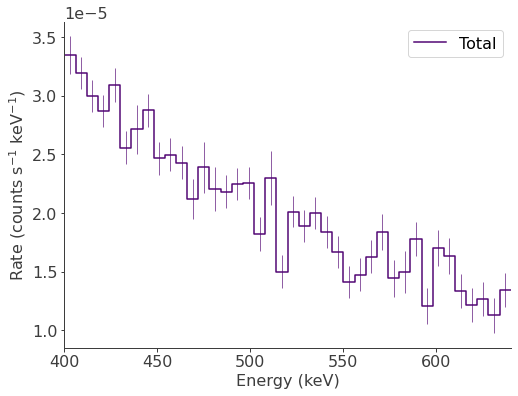

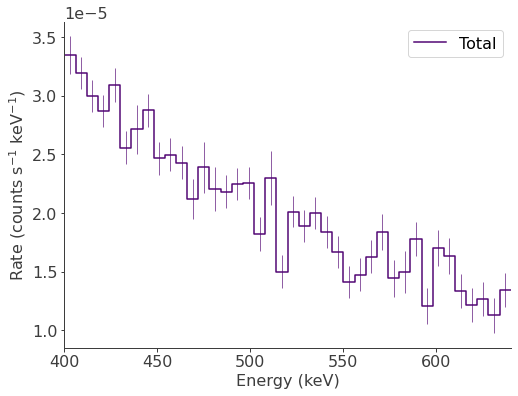

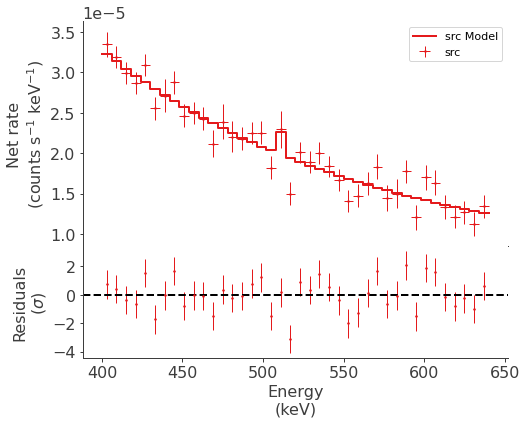

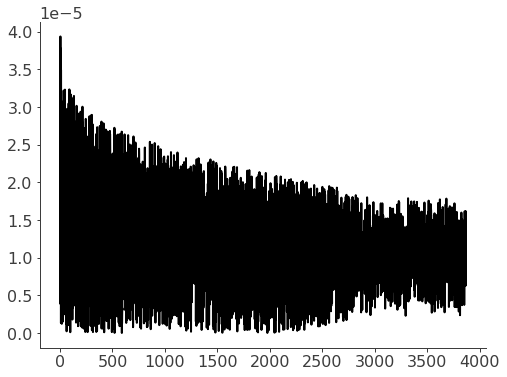

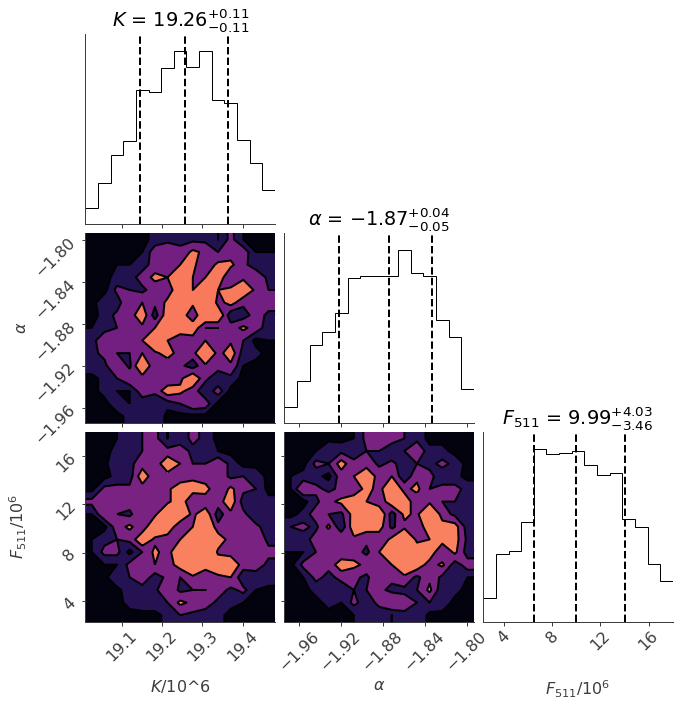

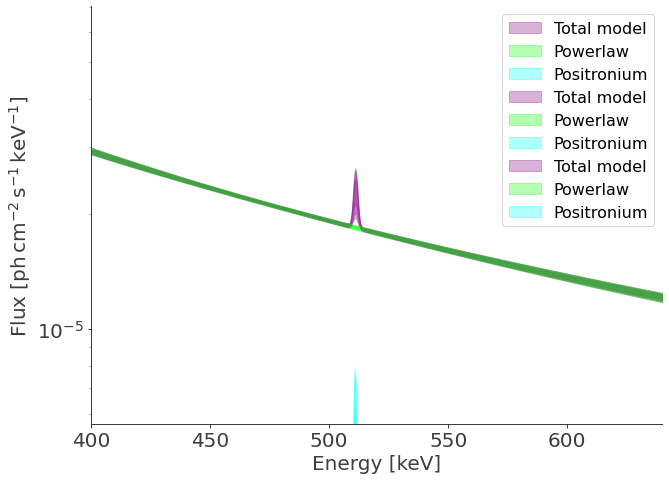

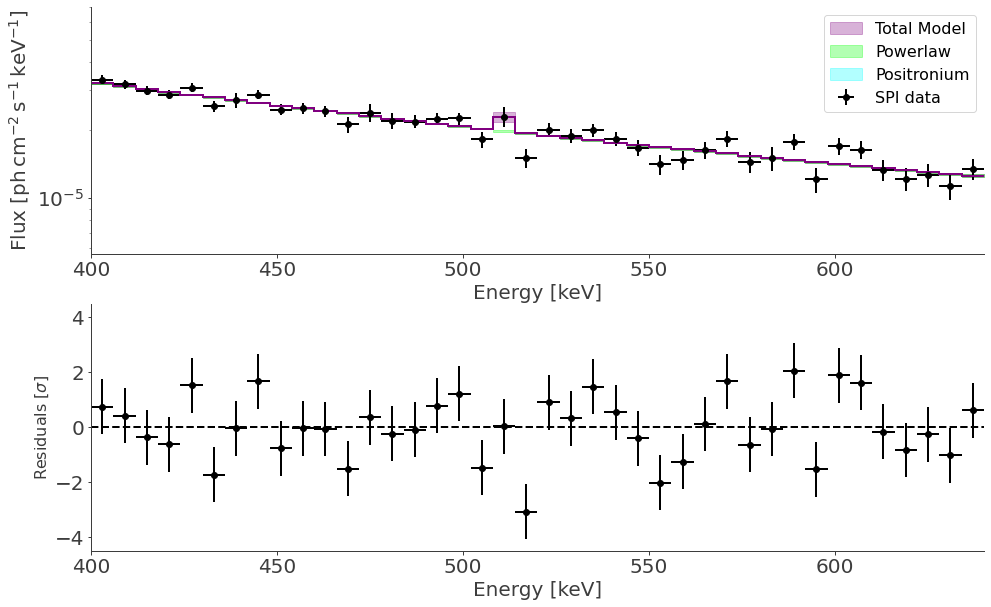

In [27]:
analyse_point_source(spec_name = 'spectra_Crab.fits')

<h1>Cygnus X-1</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 49.82 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(6.19 -0.18 +0.19) x 10^-6,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-2.27 +/- 0.23,
src.spectrum.main.composite.Flux_2,(0.0 +/- 3.1) x 10^-9,1 / (cm2 s)



Correlation matrix:



1.00,0.38,0.00
0.38,1.00,0.00
0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,21.157912
total,21.157912



Values of statistical measures:



,statistical measures
AIC,48.982490
BIC,53.382461


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is convergin


 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the ed

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 2.78e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


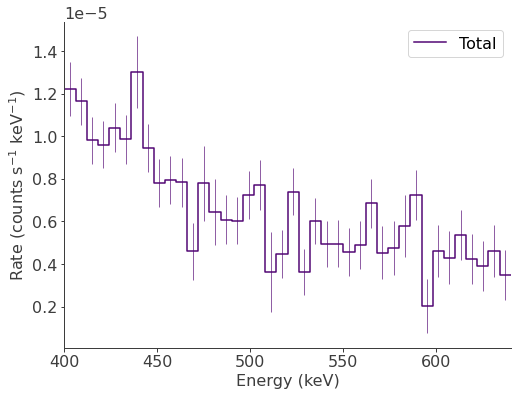

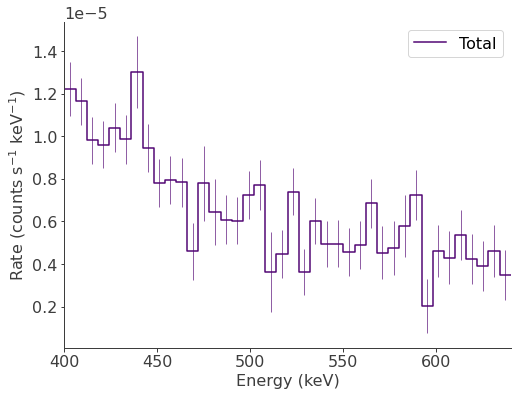

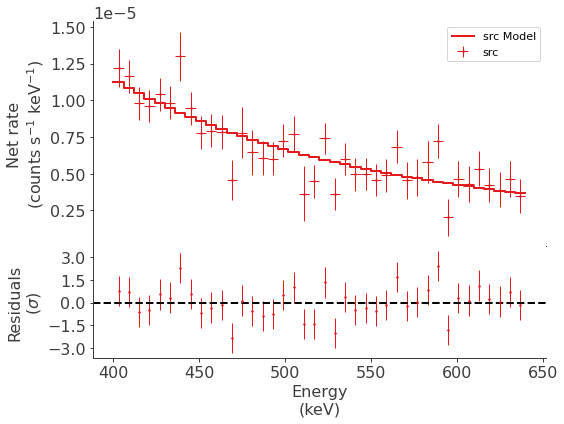

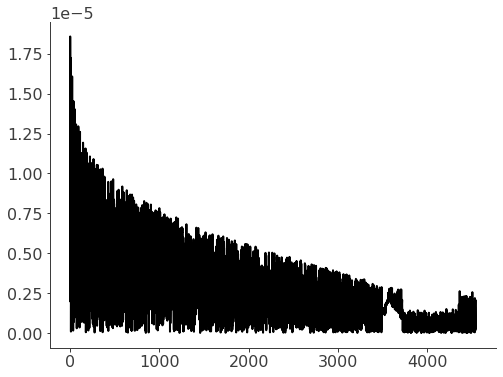

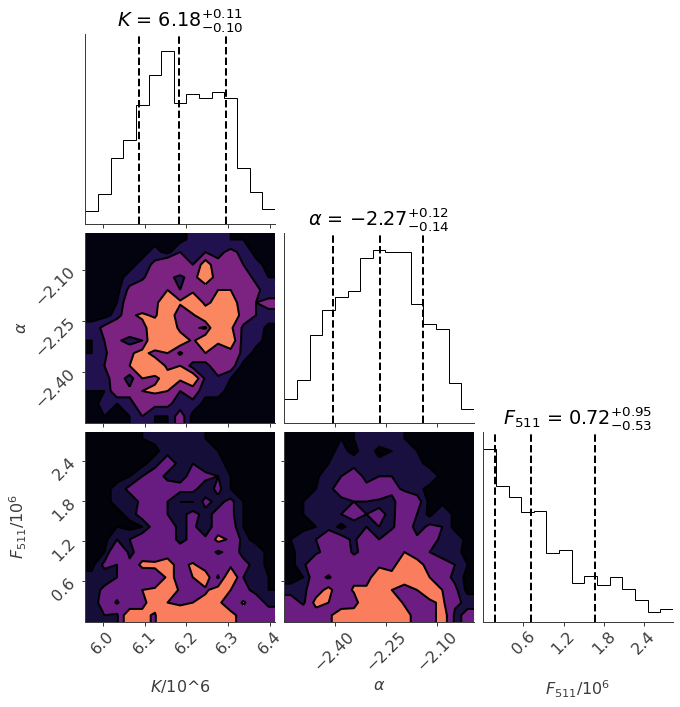

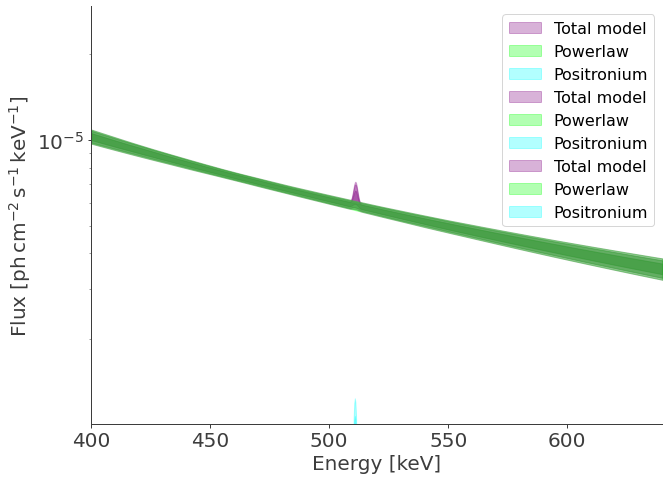

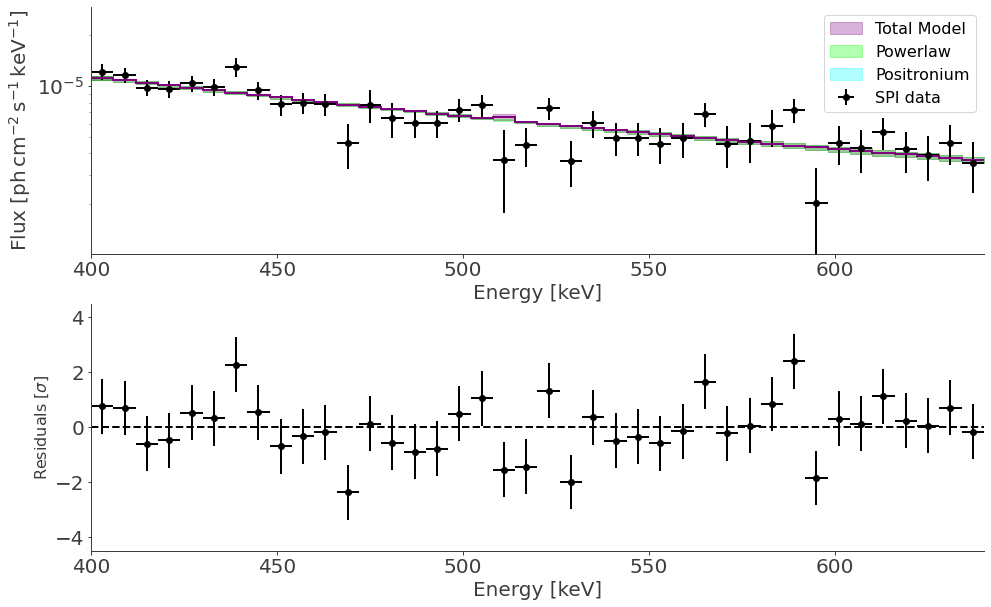

In [28]:
analyse_point_source(spec_name = 'spectra_Cyg_X-1.fits')

<h1>GRS1915</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 36.120000000000005 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(1.30 -0.16 +0.18) x 10^-6,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,(-1 +/- 10) x 10^-1,
src.spectrum.main.composite.Flux_2,(3 +/- 9) x 10^-6,1 / (cm2 s)



Correlation matrix:



1.00,-0.18,-0.13
-0.18,1.00,0.01
-0.13,0.01,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,16.01428
total,16.01428



Values of statistical measures:



,statistical measures
AIC,38.695227
BIC,43.095199


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging toward

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 8.33e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


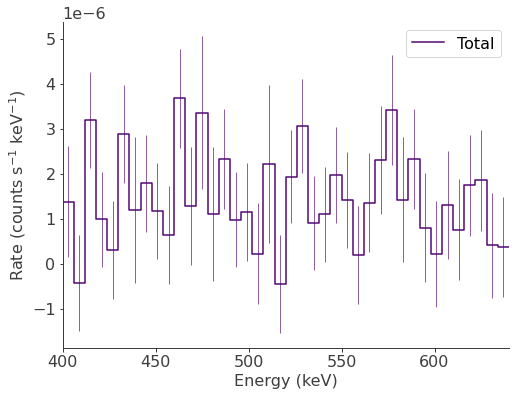

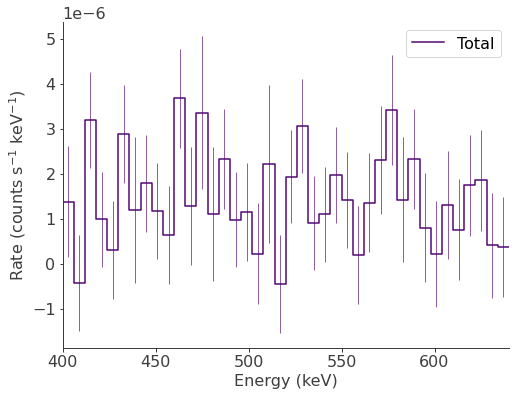

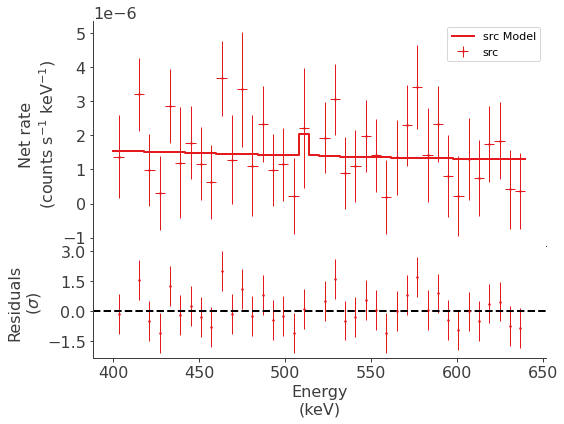

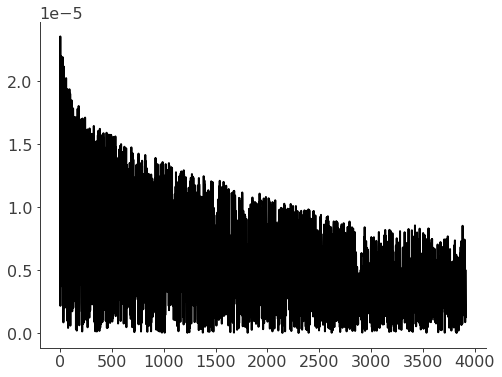

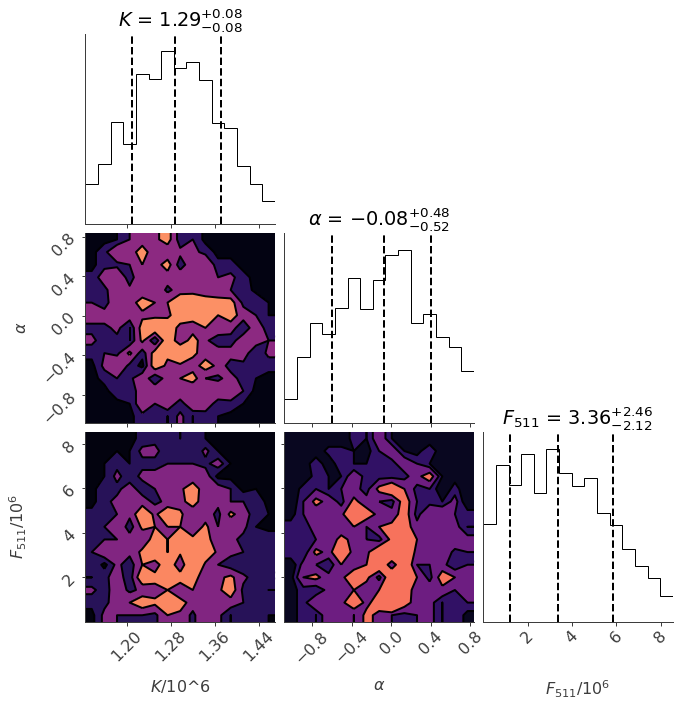

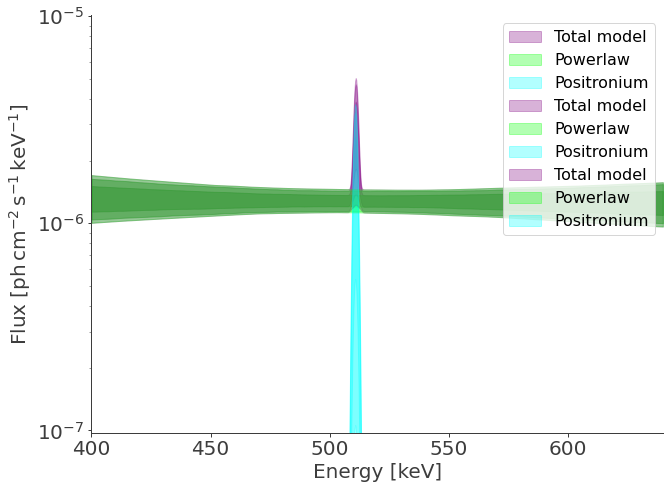

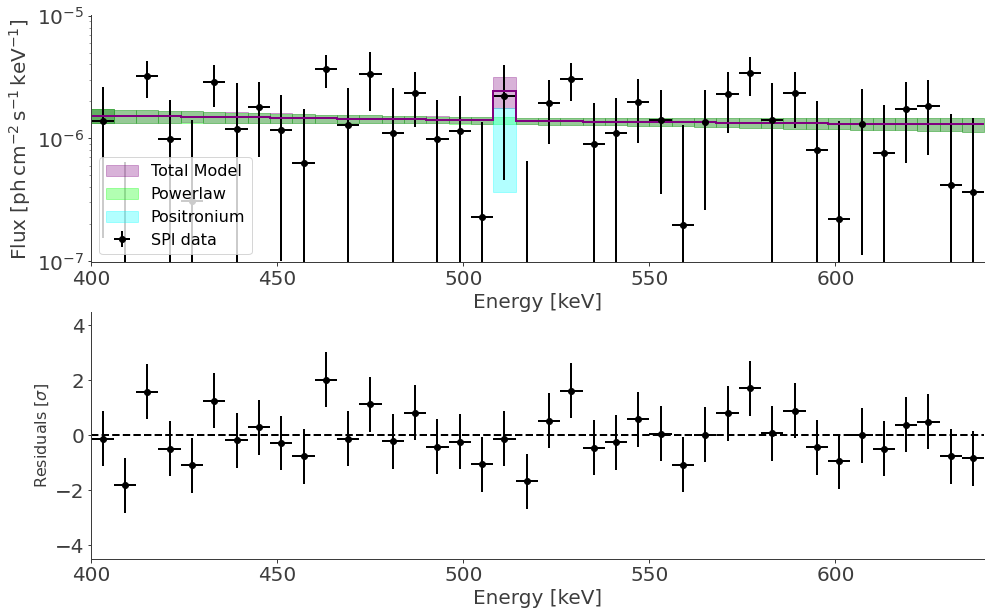

In [29]:
analyse_point_source(spec_name='spectra_GRS_1915+105.fits')

<h1>MR_2251-178</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 71.56 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(0.0 -1.7 +3.2) x 10^10,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-8 +/- 9,
src.spectrum.main.composite.Flux_2,(7 +/- 5) x 10^-5,1 / (cm2 s)



Correlation matrix:



1.00,0.00,-0.00
0.00,1.00,0.00
-0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,32.159011
total,32.159011



Values of statistical measures:



,statistical measures
AIC,70.984688
BIC,75.384660


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 8.34e-05 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


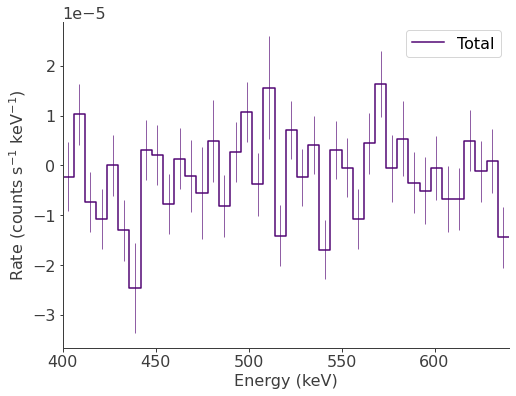

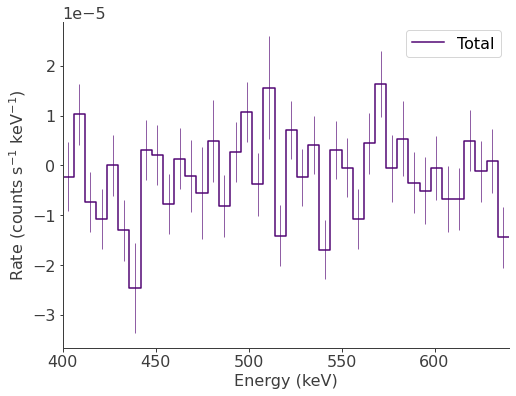

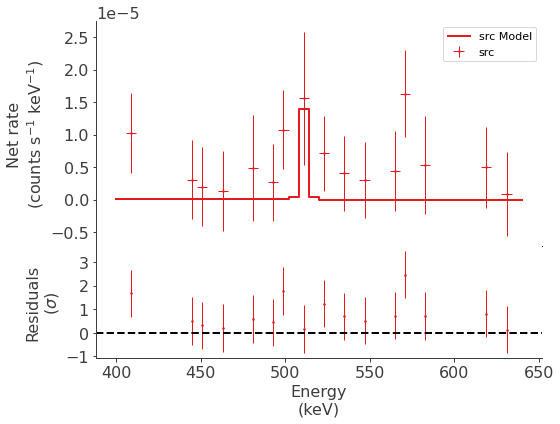

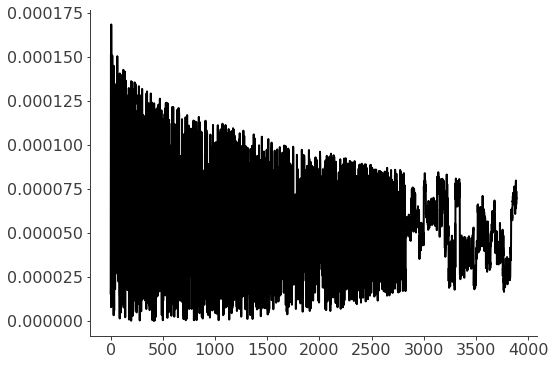

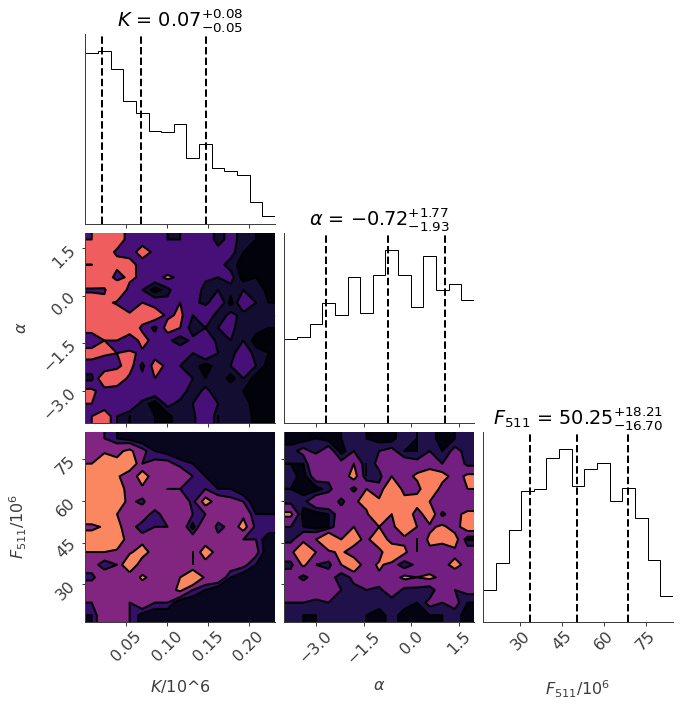

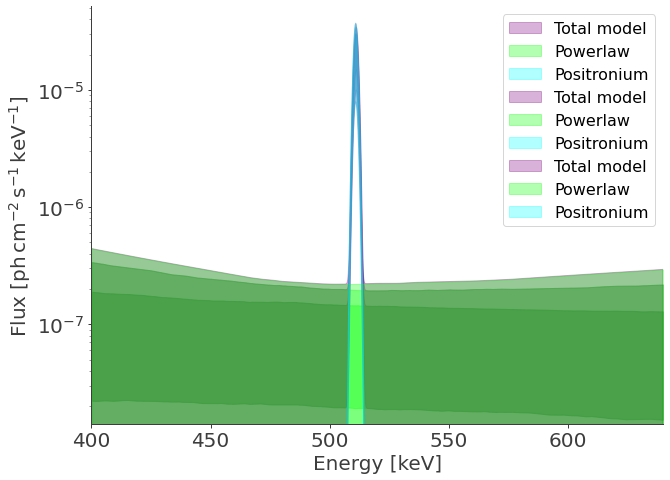

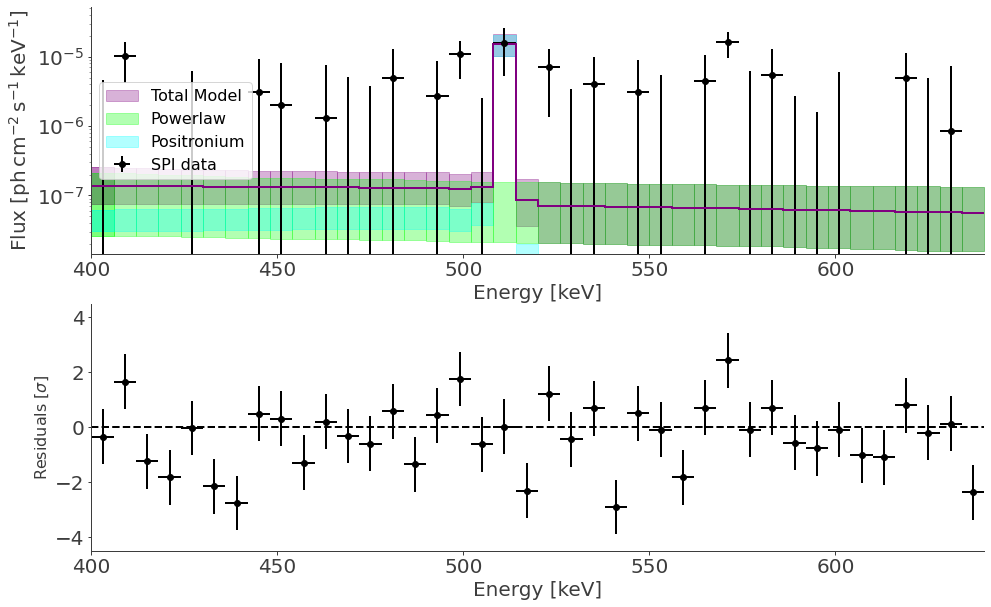

In [30]:
analyse_point_source(spec_name='spectra_MR_2251-178.fits')

<h1>Centaurus A</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 50.760000000000005 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(1.17 -0.25 +0.33) x 10^-6,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-3.9 +/- 1.7,
src.spectrum.main.composite.Flux_2,(0.0 +/- 3.4) x 10^-9,1 / (cm2 s)



Correlation matrix:



1.00,0.68,-0.00
0.68,1.00,-0.00
-0.00,-0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,32.527453
total,32.527453



Values of statistical measures:



,statistical measures
AIC,71.721573
BIC,76.121545


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging toward


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.
 ln(ev)=  -44.880531988160740      +/-  0.10227439541231351     
 Total Likelihood Evaluations:        21777
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 4.02e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


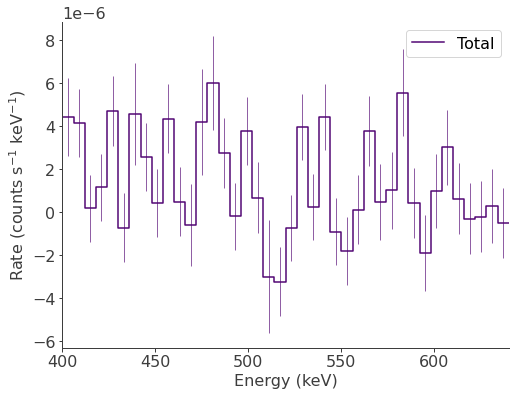

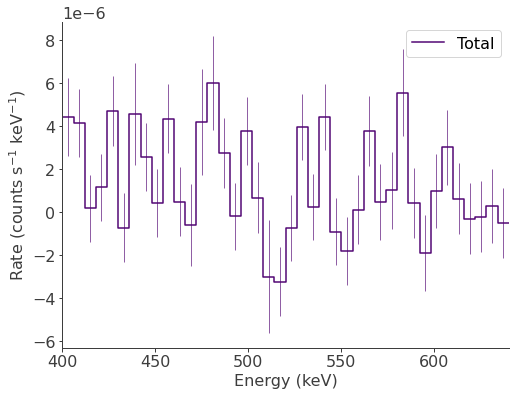

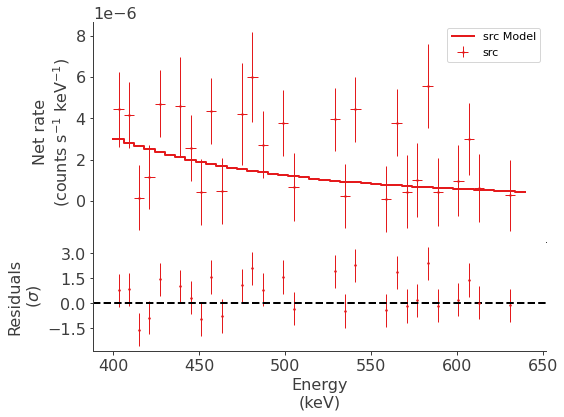

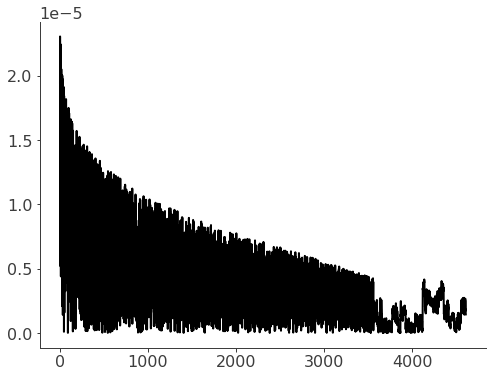

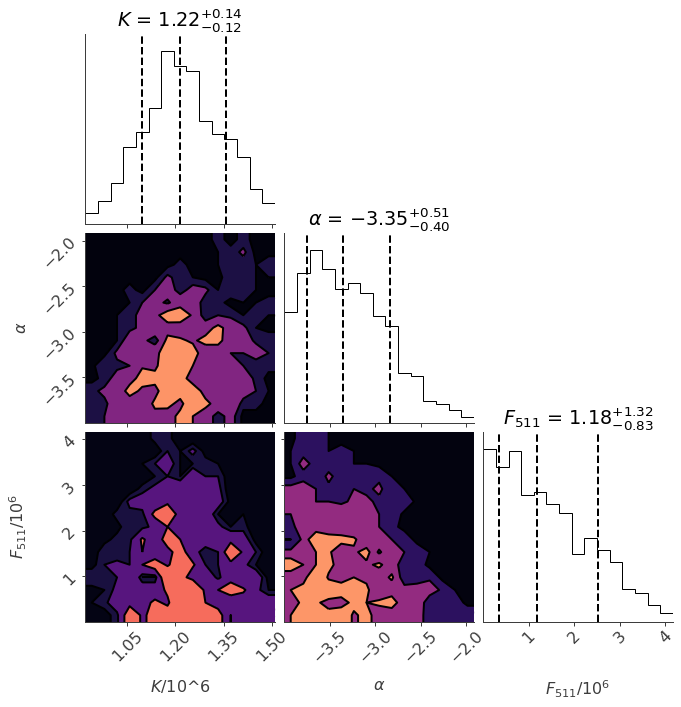

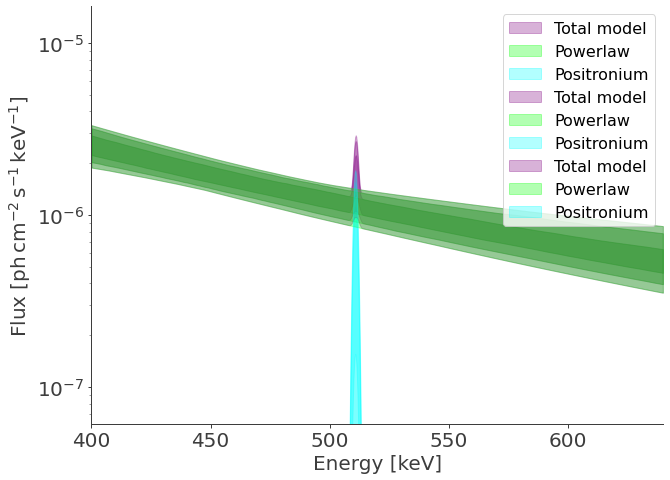

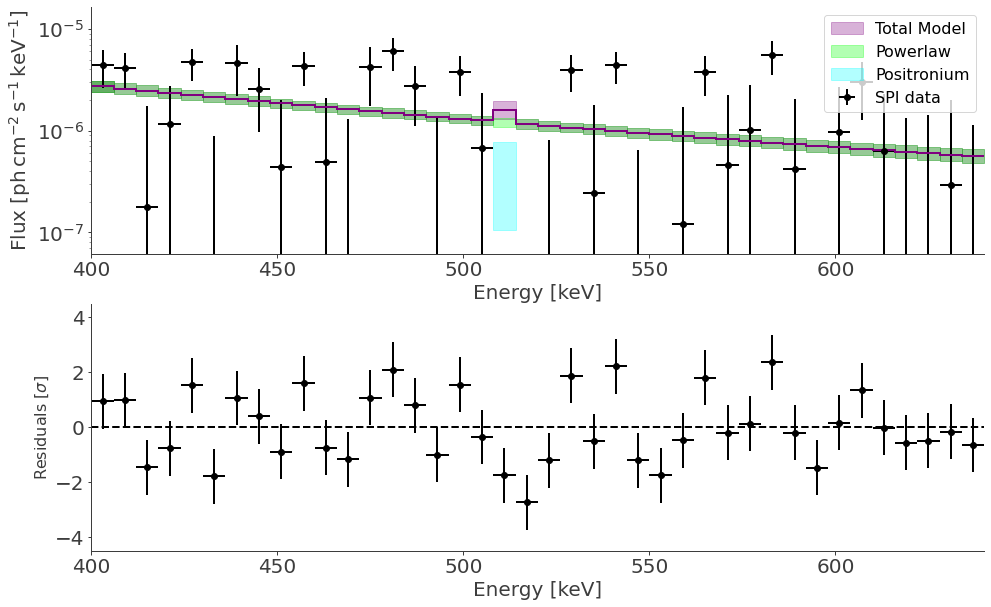

In [31]:
analyse_point_source(spec_name='spectra_Cen_A.fits')

<h1>3C 273</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 48.94 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(6.5 -1.9 +2.6) x 10^-7,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,1.2 +/- 2.3,
src.spectrum.main.composite.Flux_2,(0 +/- 7) x 10^-8,1 / (cm2 s)



Correlation matrix:



1.00,-0.47,-0.00
-0.47,1.00,0.00
-0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,37.898492
total,37.898492



Values of statistical measures:



,statistical measures
AIC,82.463650
BIC,86.863622


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging toward

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 4.02e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


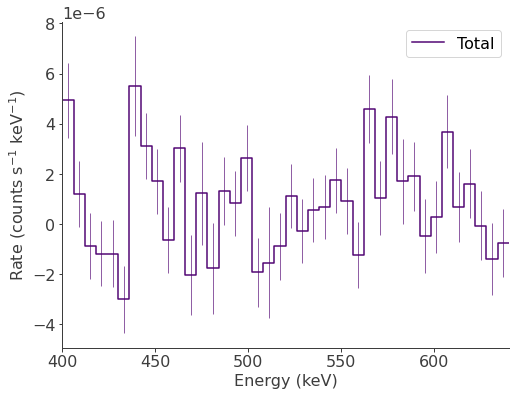

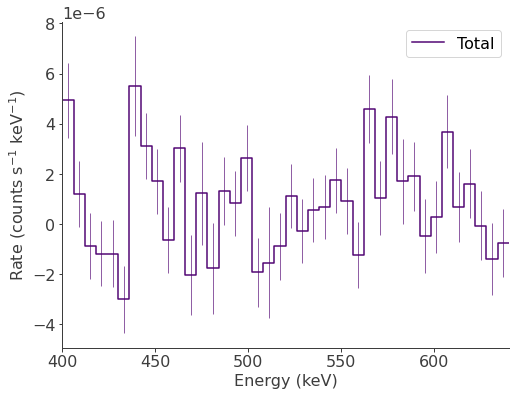

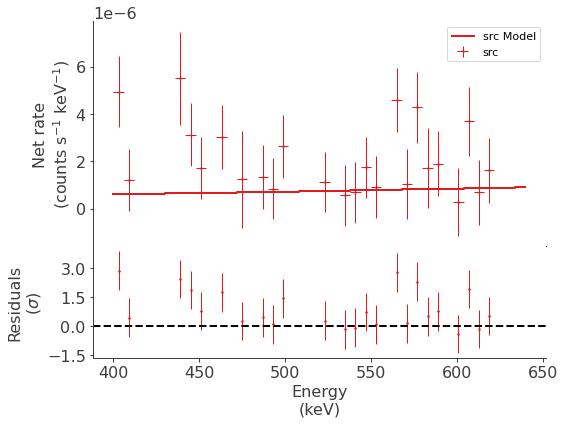

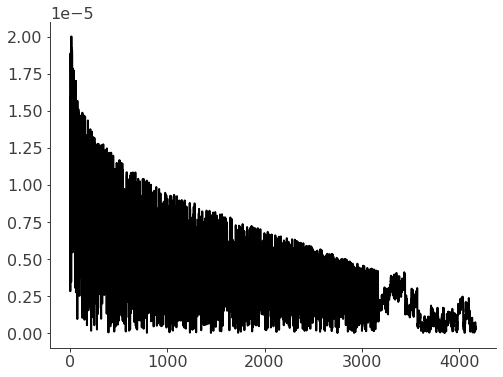

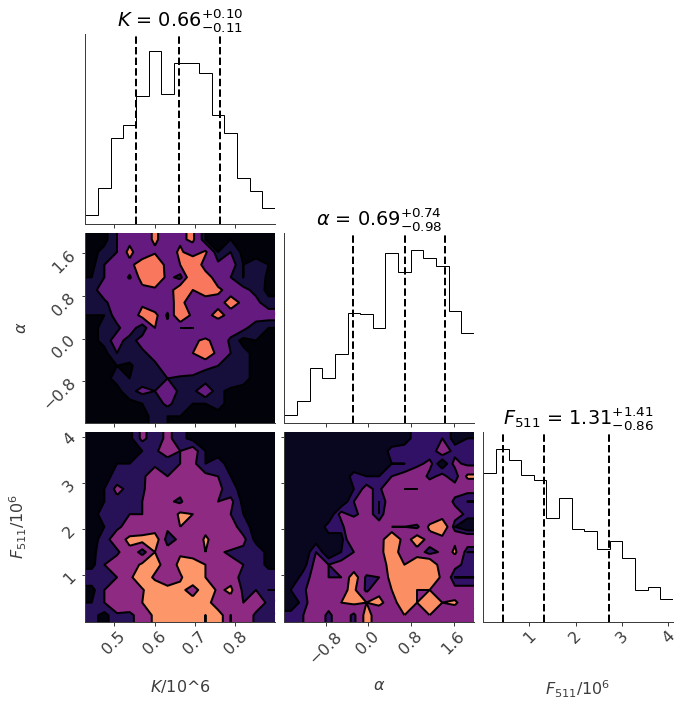

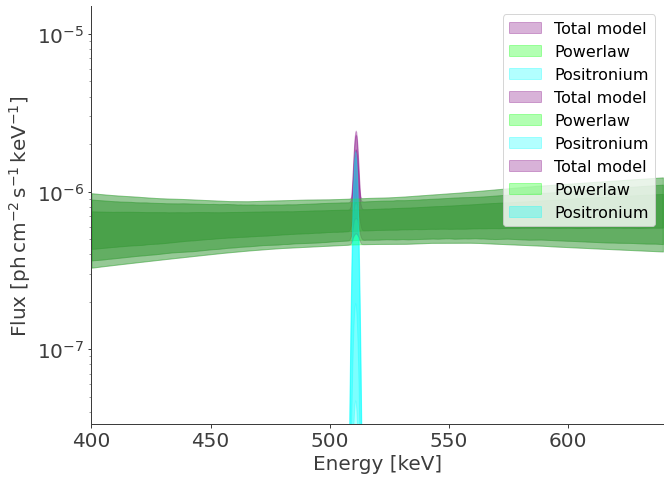

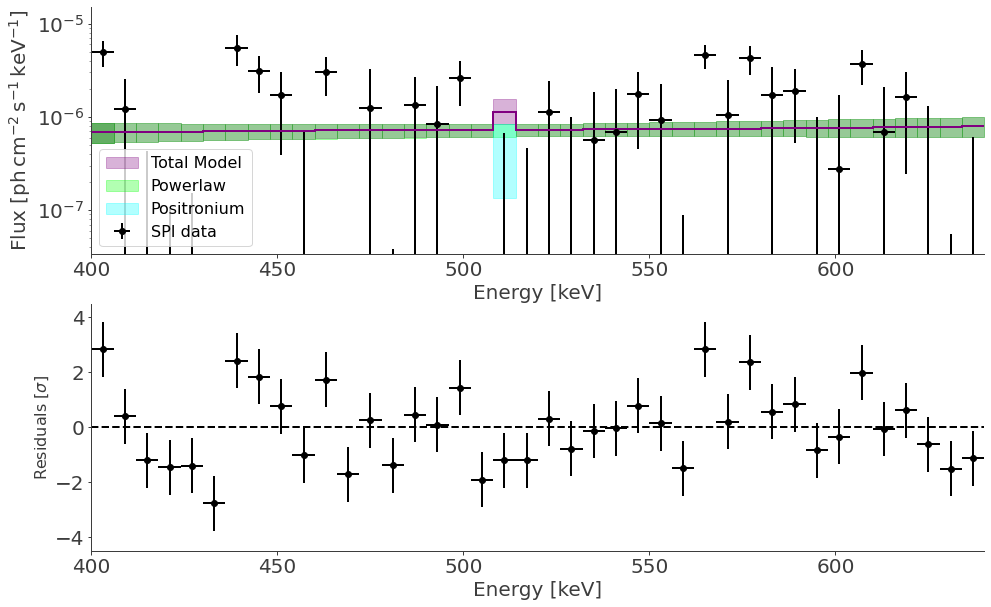

In [32]:
analyse_point_source(spec_name='spectra_3C_273.fits')

<h1>PSR B1509-58</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 49.26 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(1.34 -0.19 +0.22) x 10^-6,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-0.4 +/- 1.1,
src.spectrum.main.composite.Flux_2,(0.0 +/- 1.5) x 10^-7,1 / (cm2 s)



Correlation matrix:



1.00,-0.11,-0.00
-0.11,1.00,0.00
-0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,24.814488
total,24.814488



Values of statistical measures:



,statistical measures
AIC,56.295643
BIC,60.695615


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging toward

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 7.51e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


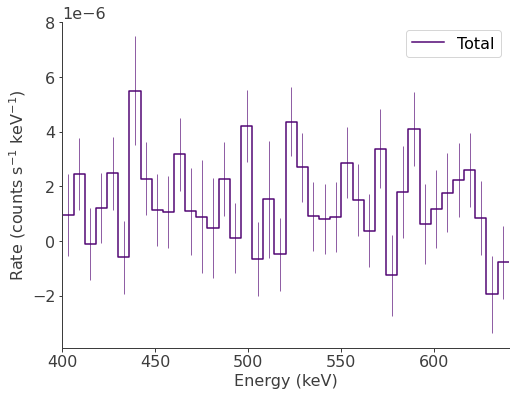

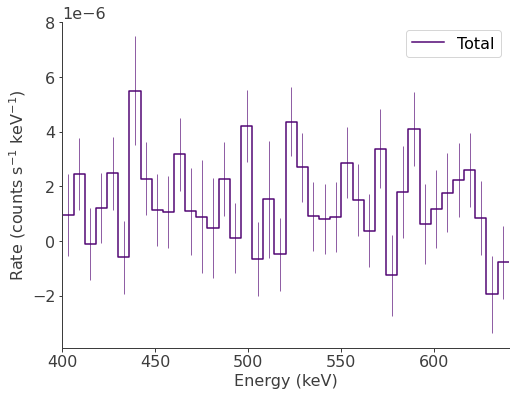

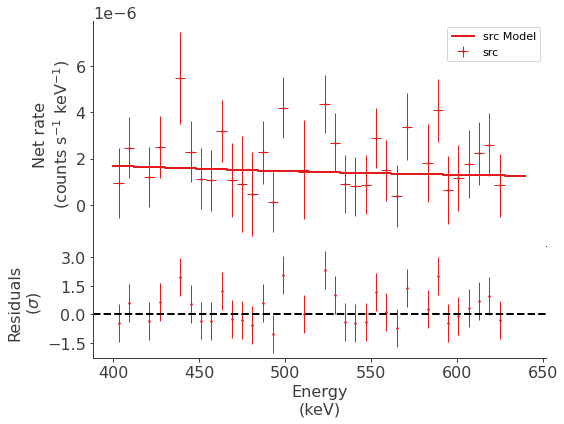

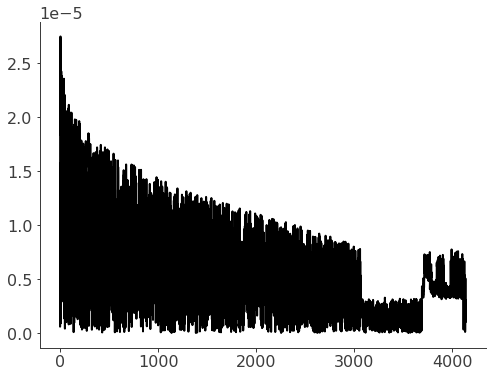

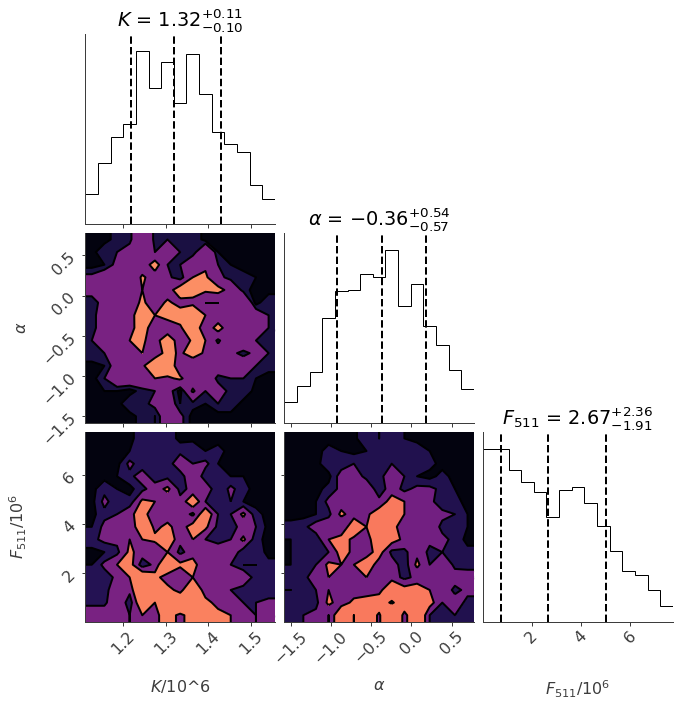

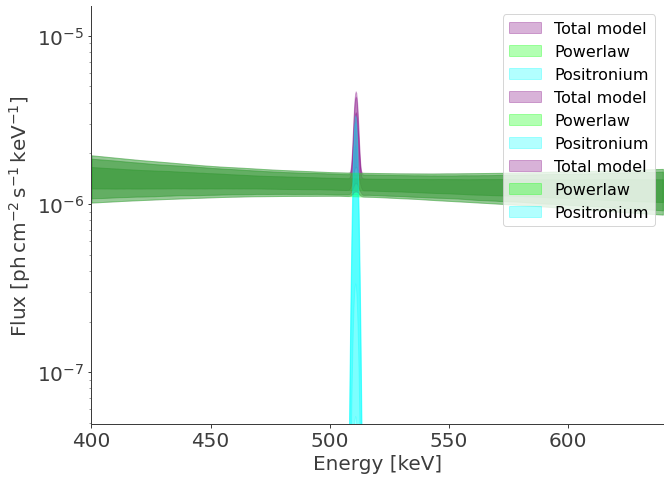

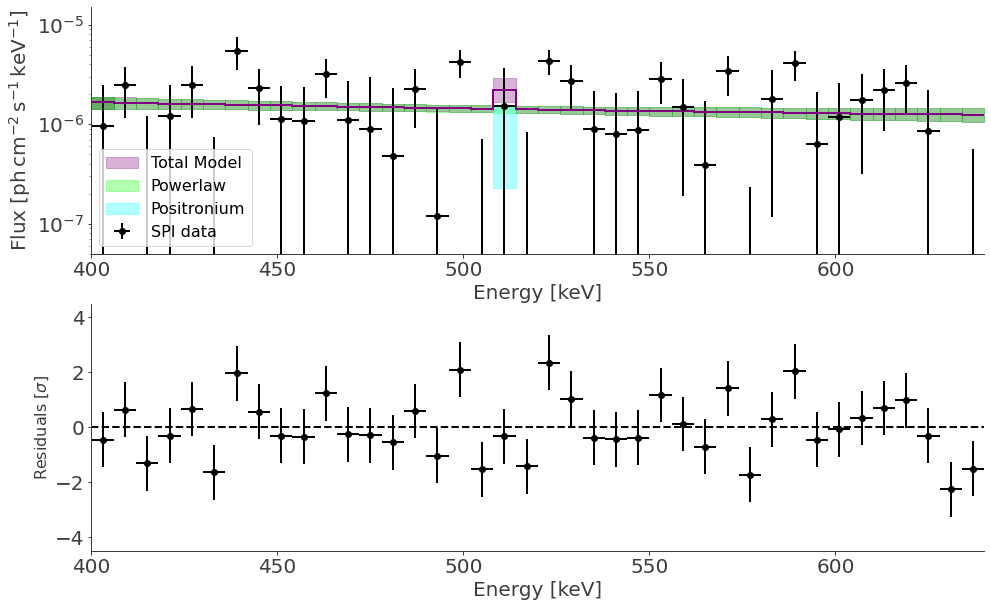

In [33]:
analyse_point_source(spec_name='spectra_PSR_B1509-58.fits')

<h1>SWIFT J1753.5-0127</h1>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 50.44 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(2.45 -0.23 +0.25) x 10^-6,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-1.9 +/- 0.8,
src.spectrum.main.composite.Flux_2,(0 +/- 7) x 10^-11,1 / (cm2 s)



Correlation matrix:



1.00,0.28,0.00
0.28,1.00,0.00
0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,33.82571
total,33.82571



Values of statistical measures:



,statistical measures
AIC,74.318086
BIC,78.718057


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is convergin


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging toward


 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.
  analysing data from chains/fit-.txt ln(ev)=  -46.096234998088789      +/-  0.10238151817280790     
 Total Likelihood Evaluations:        24397
 Sampling finished. Exiting MultiNest



  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 3.06e-06 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


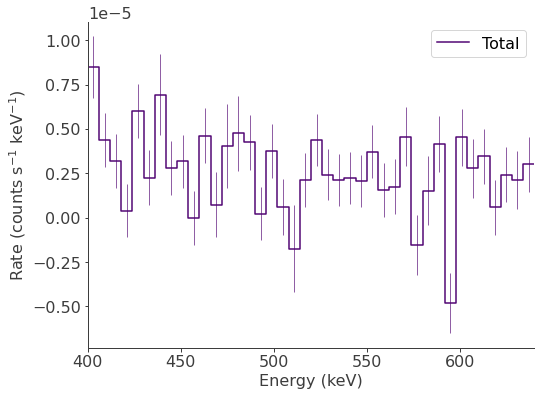

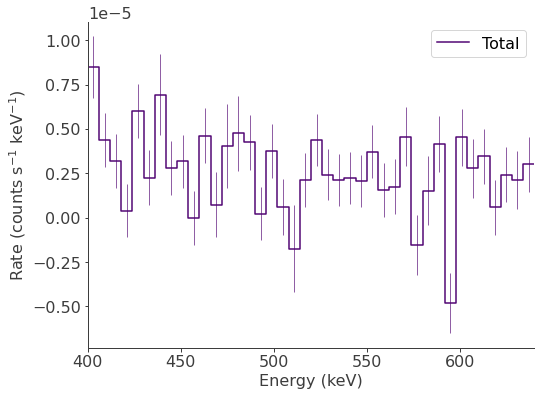

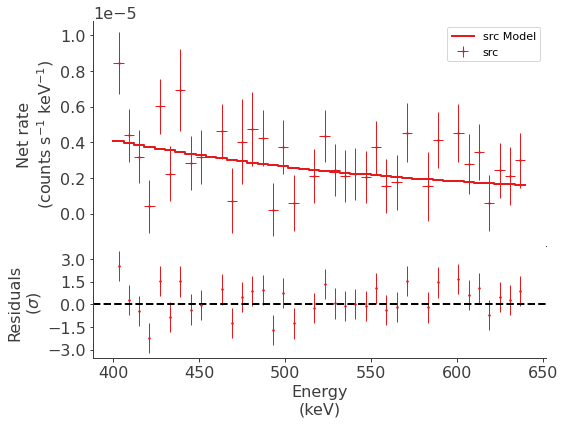

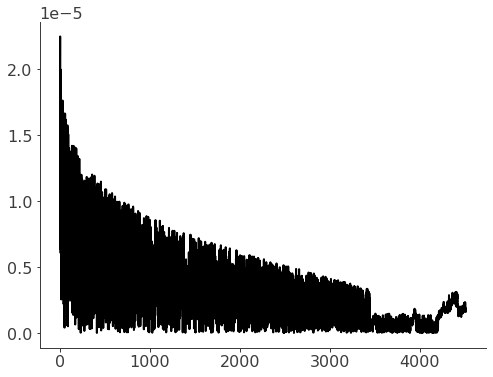

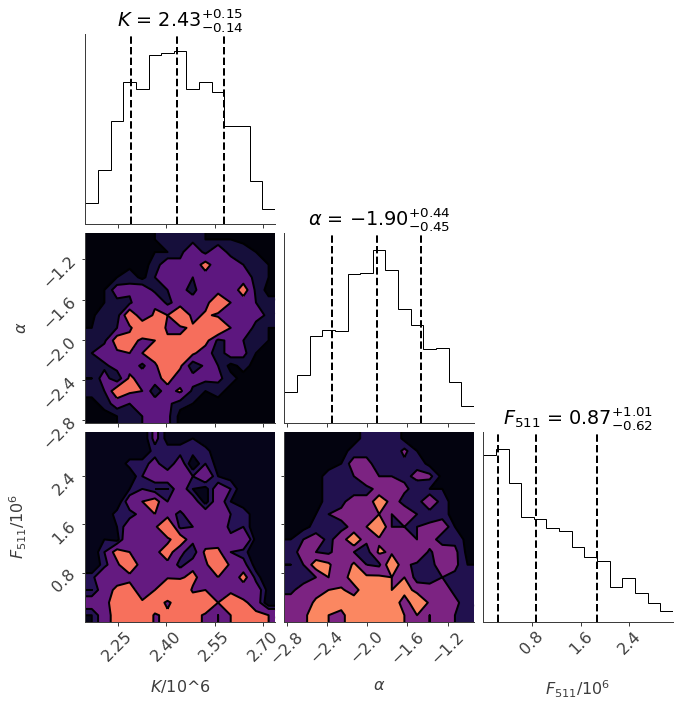

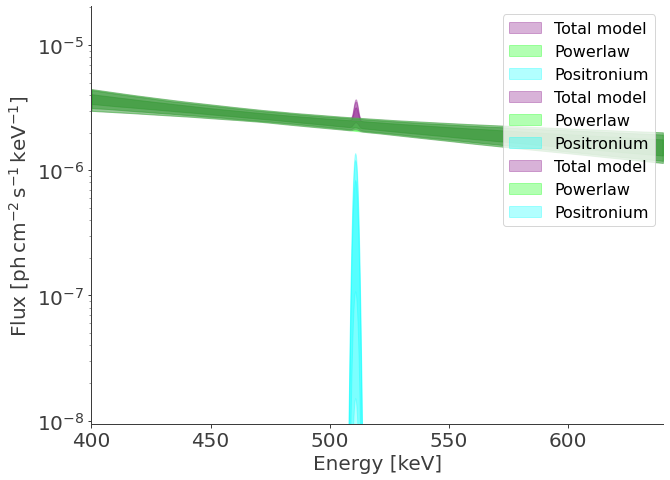

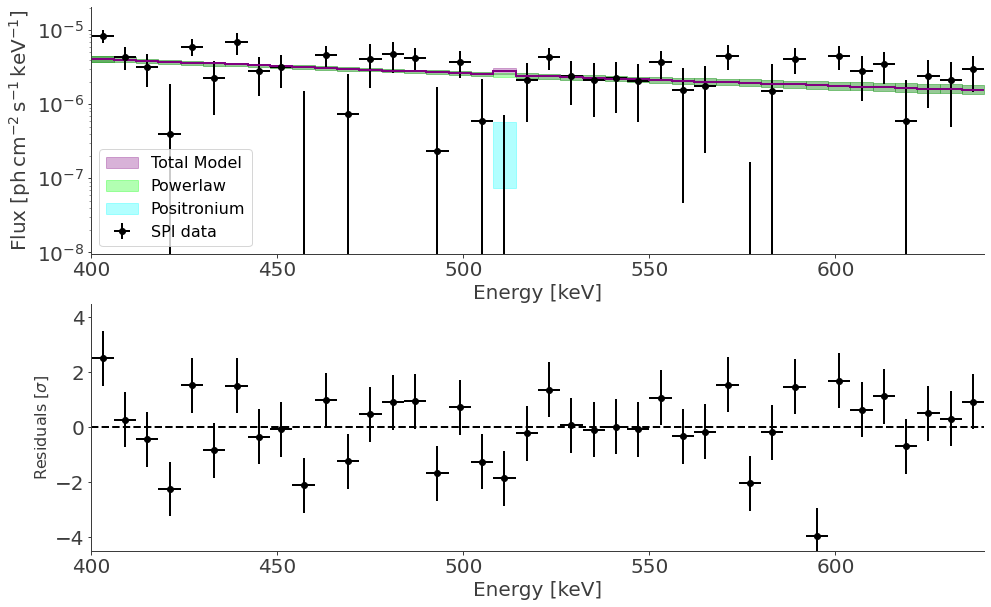

In [34]:
analyse_point_source(spec_name='spectra_SWIFT_J1753.5-0127.fits')

<h1>all sources combined</h1>

[WARNING ] unable to find SPECTRUM extension: not OGIP PHA!
[WARNING ] File has no SPECTRUM extension, but found a spectrum in extension SPI.-PHA1-SPE
[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c39 translates to channels 0-39


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                       value min_value max_value  \
src.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
src.spectrum.main.composite.index_1     -2.2     -10.0      10.0   
src.spectrum.main.composite.Flux_2   0.00001       0.0    1000.0   

                                               unit  
src.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
src.spectrum.main.composite.index_1                  
src.spectrum.main.composite.Flux_2         s-1 cm-2  

Fixed parameters (6):
---------------------

                                     value min_value max_value unit
src.position.l                         0.0       0.0     360.0  deg
src.position.b                         0.0     -90.0      90.0  deg
src.spectrum.main.composite.piv_1    500.0      None      None  keV
src.spectrum.main.composite.mu_2     511.0     490.0     530.0  keV
src.spectrum.main.composite.sigma_2    1.4      0.81      20.0  keV
src.spectrum.main.composite.f_Ps_2     0.0       0.0       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

[INFO    ] set the minimizer to minuit
[WARNING ] 34.18 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
src.spectrum.main.composite.K_1,(3.07 -0.11 +0.12) x 10^-5,1 / (cm2 keV s)
src.spectrum.main.composite.index_1,-1.81 +/- 0.28,
src.spectrum.main.composite.Flux_2,(3 +/- 6) x 10^-5,1 / (cm2 s)



Correlation matrix:



1.00,0.26,-0.13
0.26,1.00,-0.04
-0.13,-0.04,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
src,54.732204
total,54.732204



Values of statistical measures:



,statistical measures
AIC,116.131076
BIC,120.531047


[WARNING ] External parameter cons_src already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            3  of mode            1  is convergin

  0%|          | 0/1000 [00:00<?, ?it/s]

|---------------------------------------------------|
|---------------------------------------------------|
|511 keV line 3-sigma upper limit: 6.54e-05 ph/cm2/s|
|---------------------------------------------------|
|---------------------------------------------------|


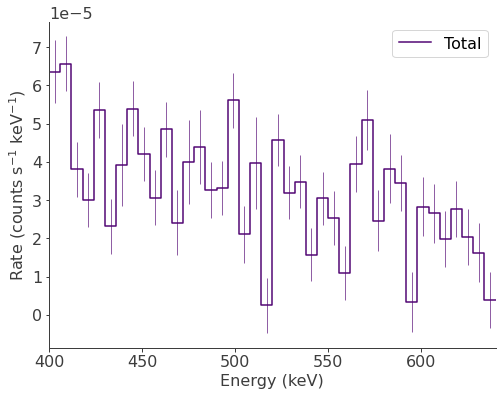

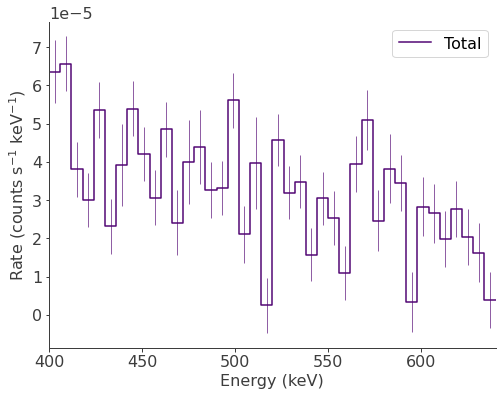

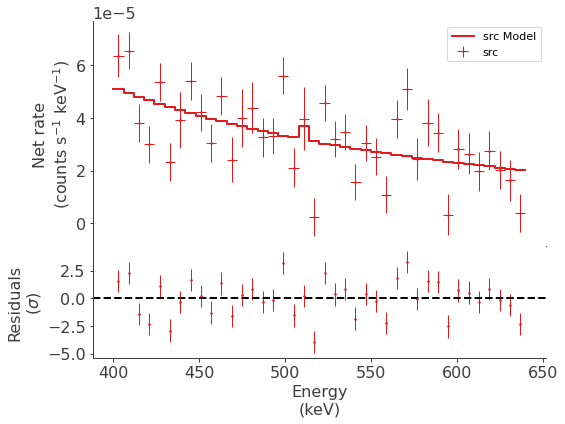

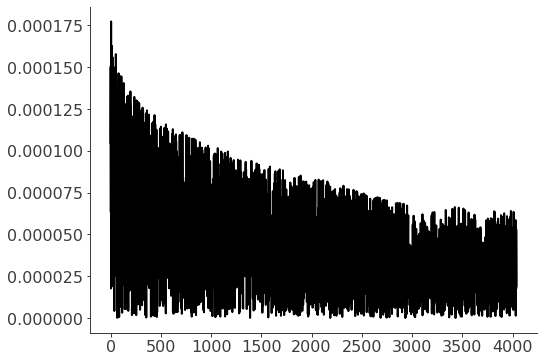

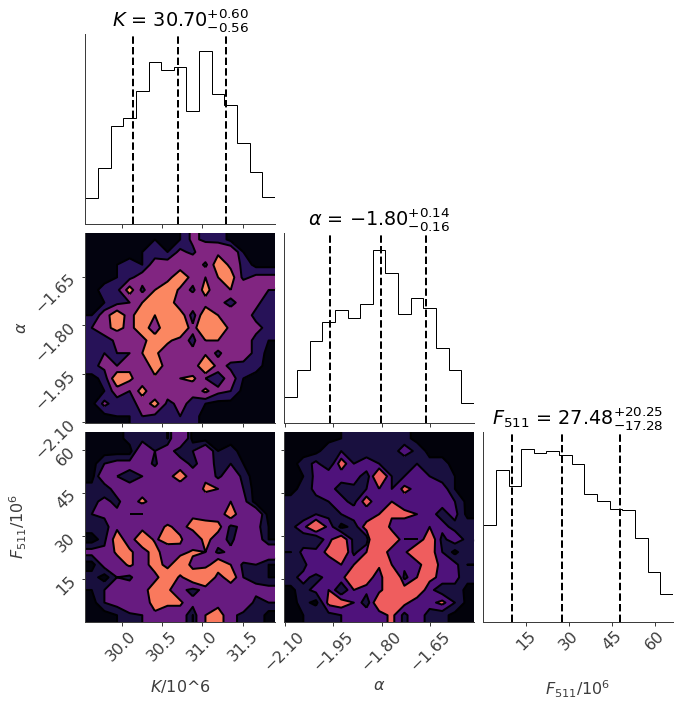

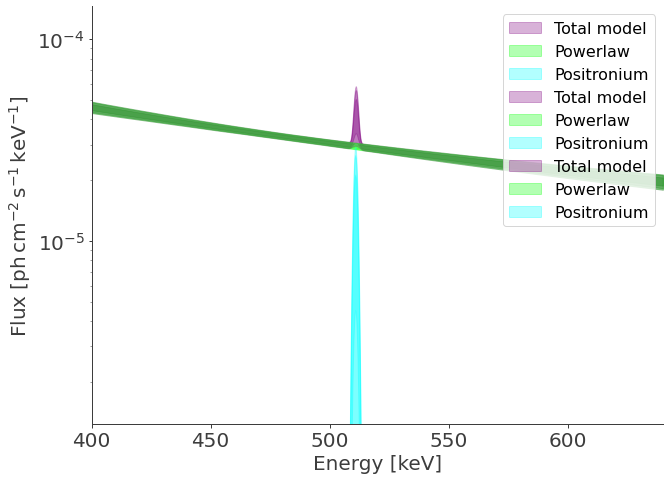

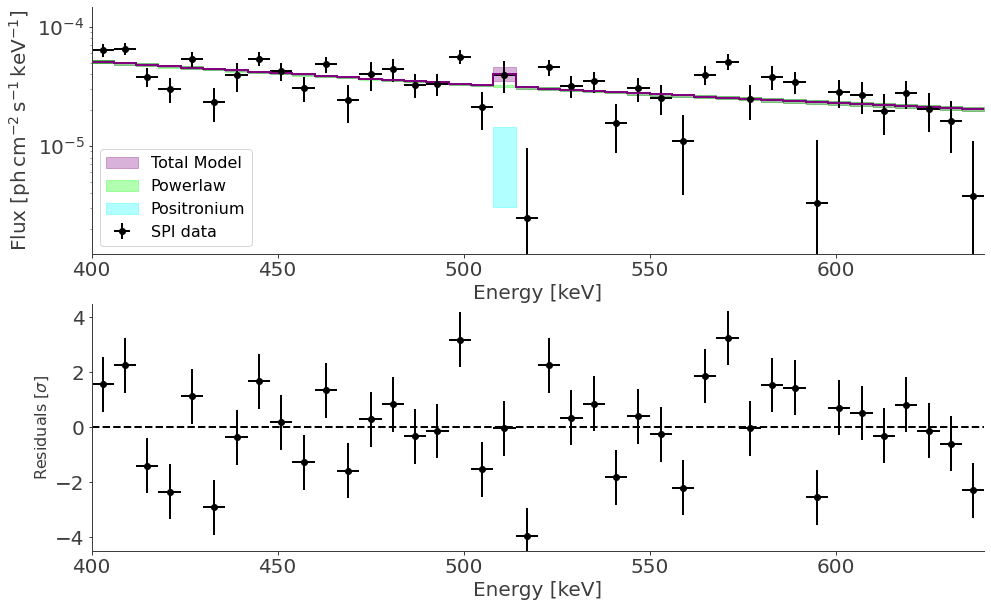

In [35]:
analyse_point_source(spec_name='spectra_AllSrces.fits')